In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import skew, kurtosis, shapiro

In [3]:
#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [4]:
df = pd.read_csv('Ventas.csv', parse_dates=['Fecha'], dayfirst=False, index_col='Fecha')

df.index = pd.to_datetime(df.index, format='%Y-%m-%d', errors='coerce')

# Now you can access the parsed dates
print(df.head())

            Gas licuado de petróleo  Gasolina regular  Gasolina superior  \
Fecha                                                                      
2000-01-01            194410.476190         202645.20          308156.82   
2000-02-01            174710.552381         205530.96          307766.31   
2000-03-01            189234.066667         229499.56          331910.29   
2000-04-01            174330.607143         210680.40          315648.08   
2000-05-01            191745.147619         208164.34          319667.97   

               Diesel  
Fecha                  
2000-01-01  634667.06  
2000-02-01  642380.66  
2000-03-01  699807.25  
2000-04-01  586803.98  
2000-05-01  656948.20  


# Series de tiempo #

In [5]:
train_size = int(len(df) * 0.7)
train_df = df[0:train_size]
test_df = df[train_size:len(df)]

In [6]:
Gasl_df = train_df['Gas licuado de petróleo']
Gasl_df.head(10)

Gasl_df

Fecha
2000-01-01    194410.476190
2000-02-01    174710.552381
2000-03-01    189234.066667
2000-04-01    174330.607143
2000-05-01    191745.147619
                  ...      
2017-05-01    377542.430000
2017-06-01    378389.980000
2017-07-01    369996.240000
2017-08-01    385885.050000
2017-09-01    378419.910000
Name: Gas licuado de petróleo, Length: 213, dtype: float64

In [7]:
Gasr_df = train_df['Gasolina regular']
Gasr_df.head(10)

Fecha
2000-01-01    202645.20
2000-02-01    205530.96
2000-03-01    229499.56
2000-04-01    210680.40
2000-05-01    208164.34
2000-06-01    195088.74
2000-07-01    204556.77
2000-08-01    218388.51
2000-09-01    213906.96
2000-10-01    213606.65
Name: Gasolina regular, dtype: float64

In [8]:
Gass_df = train_df['Gasolina superior']
Gass_df.head(10)

Fecha
2000-01-01    308156.82
2000-02-01    307766.31
2000-03-01    331910.29
2000-04-01    315648.08
2000-05-01    319667.97
2000-06-01    300347.70
2000-07-01    308305.93
2000-08-01    323011.86
2000-09-01    326455.72
2000-10-01    323843.63
Name: Gasolina superior, dtype: float64

In [9]:
Gasd_df = train_df['Diesel']
Gasd_df.head(10)

Fecha
2000-01-01    634667.06
2000-02-01    642380.66
2000-03-01    699807.25
2000-04-01    586803.98
2000-05-01    656948.20
2000-06-01    570919.88
2000-07-01    576436.02
2000-08-01    593770.77
2000-09-01    590145.40
2000-10-01    641113.36
Name: Diesel, dtype: float64

# ARIMA Gas licuado #

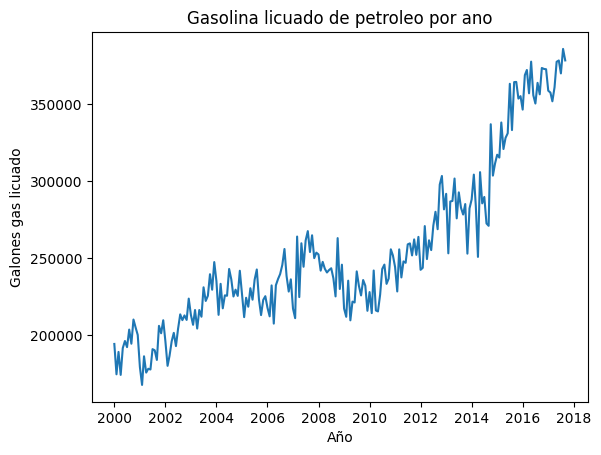

In [10]:
plt.plot(Gasl_df)
plt.gca().set(title="Gasolina licuado de petroleo por ano", xlabel="Año", ylabel="Galones gas licuado")
plt.show()

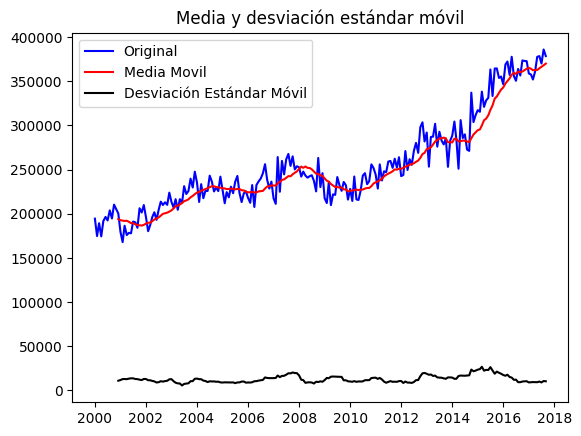

In [11]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = Gasl_df.rolling(window=12).mean()
deMovil = Gasl_df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(Gasl_df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

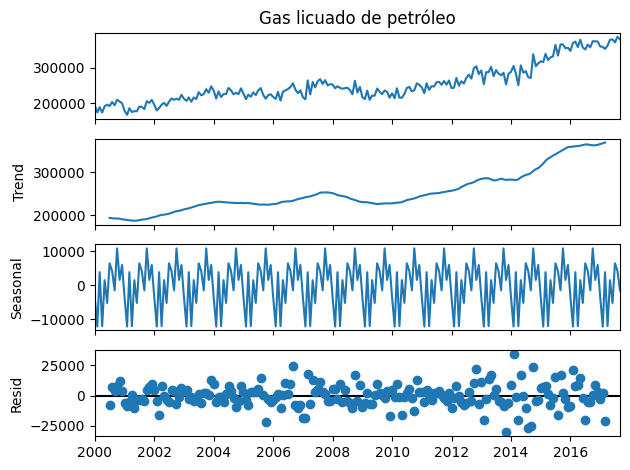

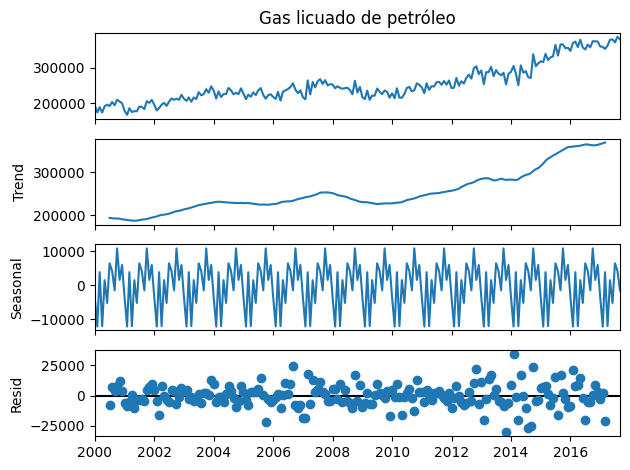

In [12]:
descomposicion = seasonal_decompose(Gasl_df)
descomposicion.plot()

Existe tendencia por lo que no parece ser estacionaria en la media ni en la varianza.

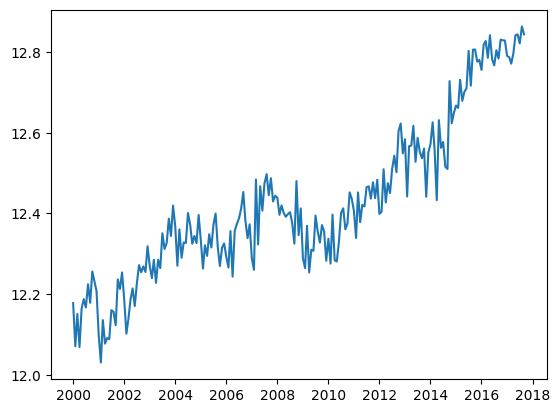

In [13]:
Gasl_df_log = np.log(Gasl_df)
plt.plot(Gasl_df_log)

Con una transformacion logaritmica la serie es estacionaria en la varianza.

In [14]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(Gasl_df, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.904203
p-value                        0.993145
# de retardos usados          12.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


No se puede rechazar la hipotesis nula por lo que la serie no es estacionaria en media.

In [15]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
Gasl_df_diff = Gasl_df.diff()
Gasl_df_diff.dropna(inplace=True)
dfTest = adfuller(Gasl_df_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.573267
p-value                        0.000145
# de retardos usados          11.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


El valor p es menor que 0.05 por lo que se rechaza la hipotesis nula por lo que no hay raices unitarias y se estacionarizo la serie en la media con una diferenciacion.

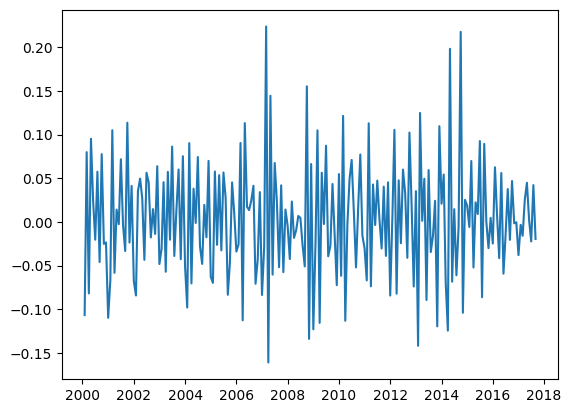

In [16]:
plt.plot(Gasl_df_log.diff())

In [17]:
Gasl_df_log_diff = Gasl_df_log.diff()
Gasl_df_log_diff.dropna(inplace = True)
tsa_acf = acf(Gasl_df_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(Gasl_df_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.52114053,  0.12269859, -0.03295786, -0.10514447,
        0.28738153])

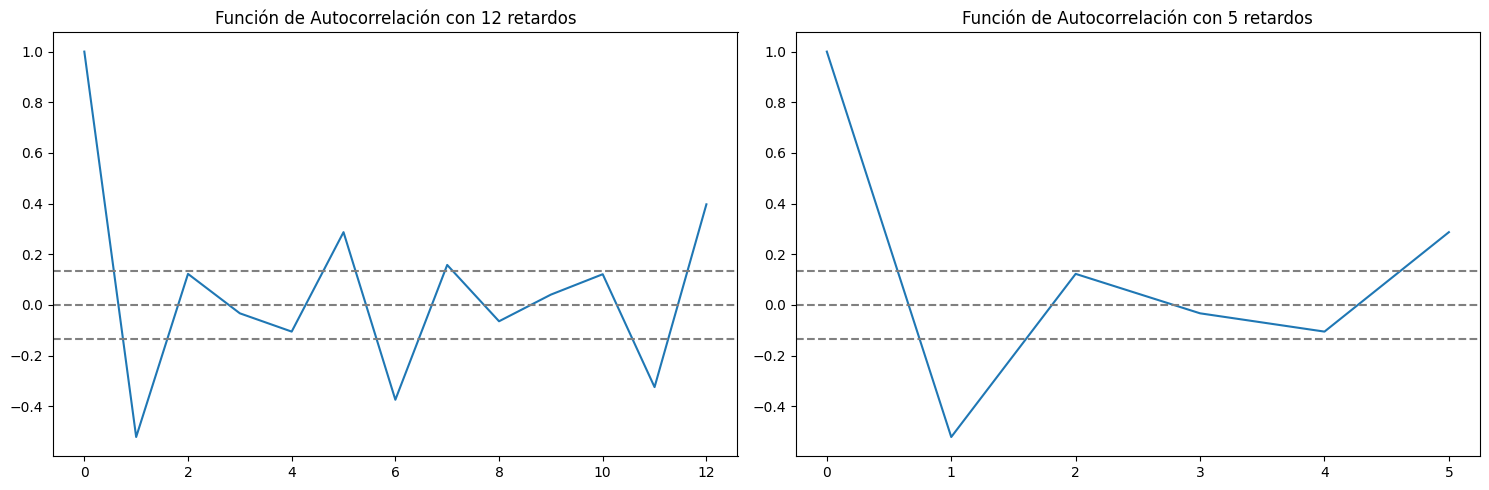

In [18]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(Gasl_df_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(Gasl_df_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

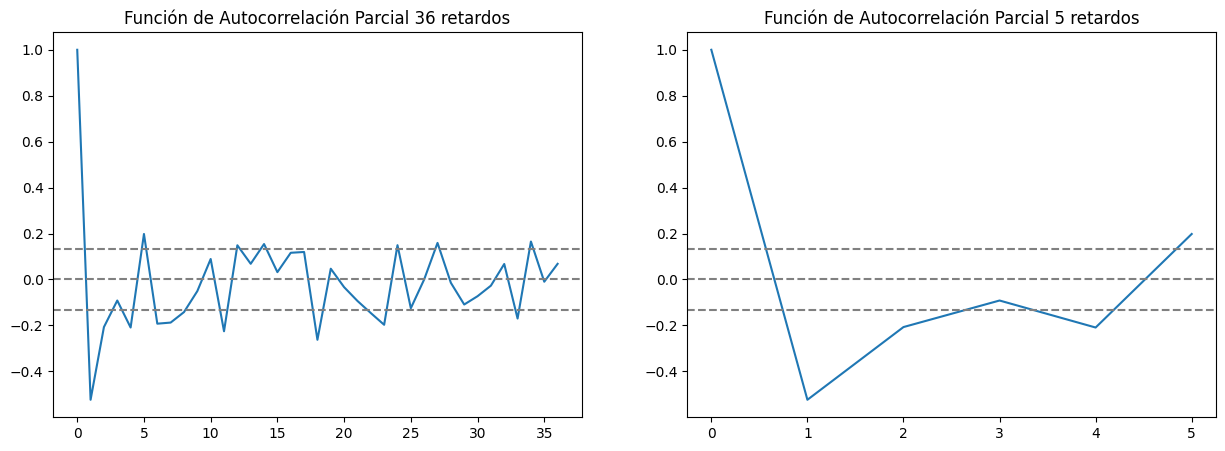

In [19]:
plt.subplot(121)
plt.plot(pacf(Gasl_df_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(Gasl_df_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Estacionalidad

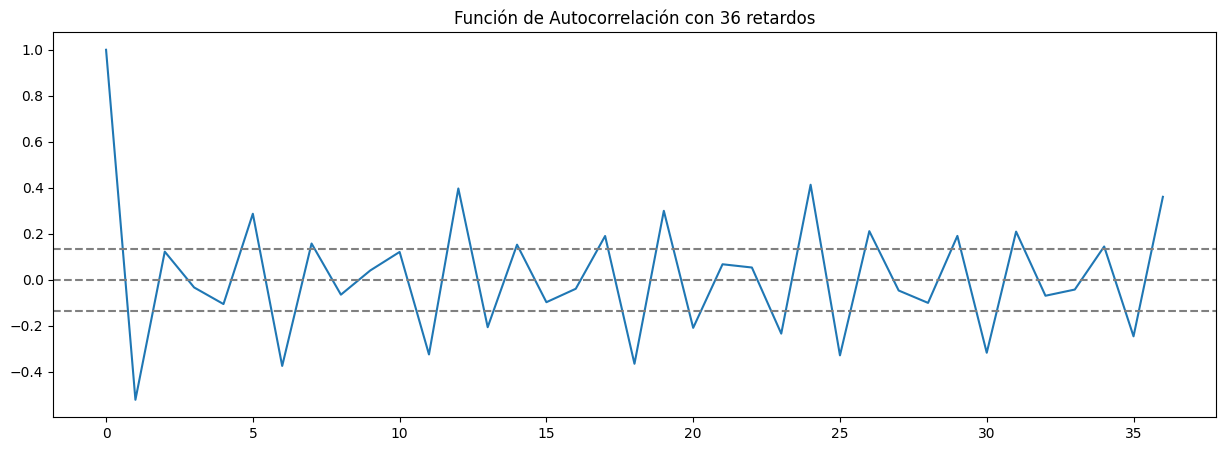

In [20]:
plt.plot(acf(Gasl_df_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Parece haber estacionalidad cada 6 meses

In [21]:
Gasl_df_log_D = Gasl_df_log.diff(6)
Gasl_df_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

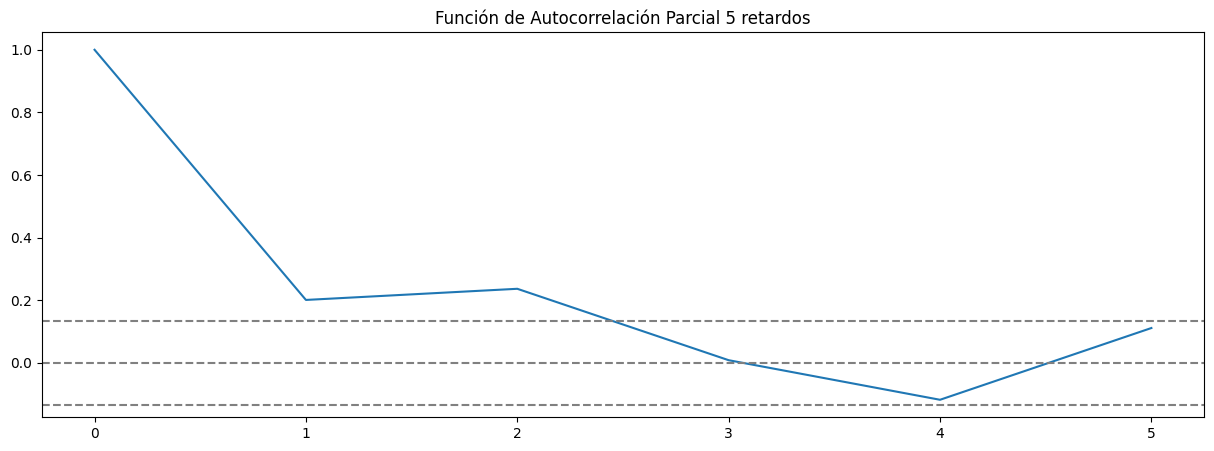

In [22]:
plt.plot(pacf(Gasl_df_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

Despues de p = 2 practicamente se anulan los coeficientes

In [23]:
modelo110 = SARIMAX(Gasl_df_log, order=(1,1,0), seasonal_order=(2,1,0,6), enforce_stationarity=False, enforce_invertibility=False)
resultado_m110 = modelo110.fit()
print(resultado_m110.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4678      0.065     -7.246      0.000      -0.594      -0.341
ar.S.L6       -0.8535      0.055    -15.447      0.000      -0.962      -0.745
ar.S.L12      -0.1609      0.058     -2.779      0.005      -0.274      -0.047
sigma2         0.0036      0.000     11.307      0.000       0.003       0.004


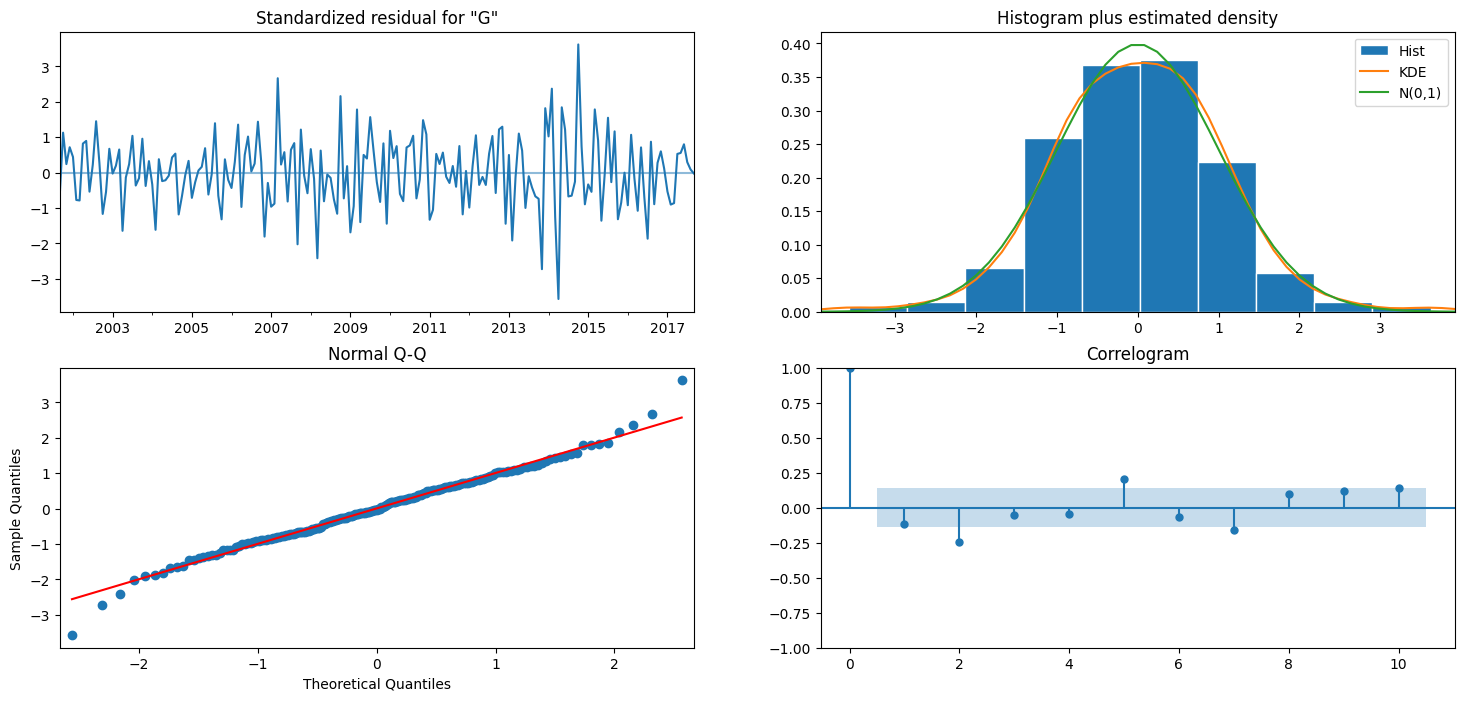

In [24]:
resultado_m110.plot_diagnostics(figsize=(18, 8))
plt.show()

In [25]:
modelo210 = SARIMAX(Gasl_df_log, order=(2,1,0), seasonal_order=(2,1,0,6), enforce_stationarity=False, enforce_invertibility=False)
resultado_m210 = modelo210.fit()
print(resultado_m210.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5826      0.076     -7.706      0.000      -0.731      -0.434
ar.L2         -0.2507      0.064     -3.940      0.000      -0.375      -0.126
ar.S.L6       -0.8460      0.057    -14.743      0.000      -0.958      -0.734
ar.S.L12      -0.1465      0.060     -2.455      0.014      -0.264      -0.030
sigma2         0.0034      0.000     11.489      0.000       0.003       0.004


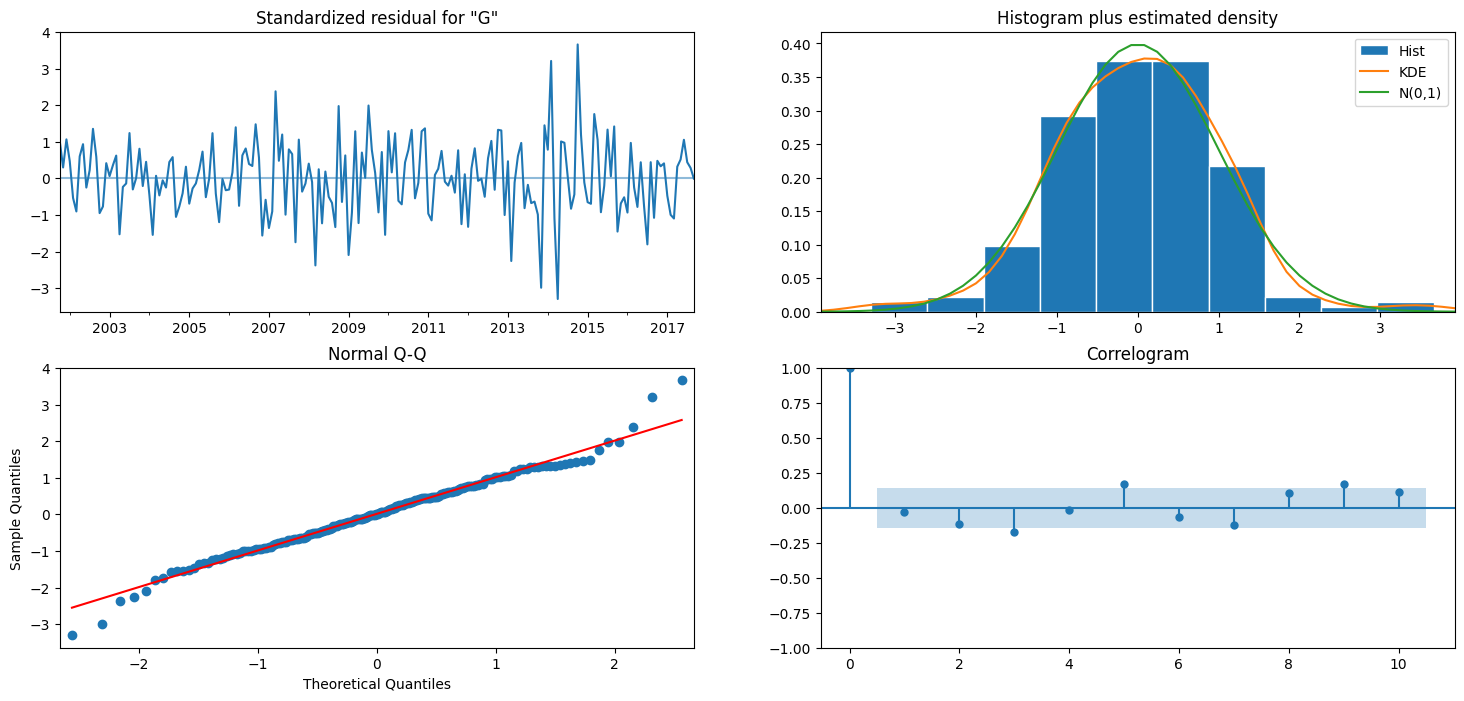

In [26]:
resultado_m210.plot_diagnostics(figsize=(18, 8))
plt.show()

In [27]:
modelo211 = SARIMAX(Gasl_df_log, order=(2,1,1), seasonal_order=(2,1,0,6), enforce_stationarity=False, enforce_invertibility=False)
resultado_m211 = modelo211.fit()
print(resultado_m211.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0423      0.154     -0.274      0.784      -0.345       0.260
ar.L2         -0.0170      0.096     -0.178      0.859      -0.205       0.171
ma.L1         -0.6080      0.126     -4.815      0.000      -0.855      -0.361
ar.S.L6       -0.8167      0.060    -13.665      0.000      -0.934      -0.700
ar.S.L12      -0.1078      0.062     -1.740      0.082      -0.229       0.014
sigma2         0.0032      0.000     11.303      0.000       0.003       0.004


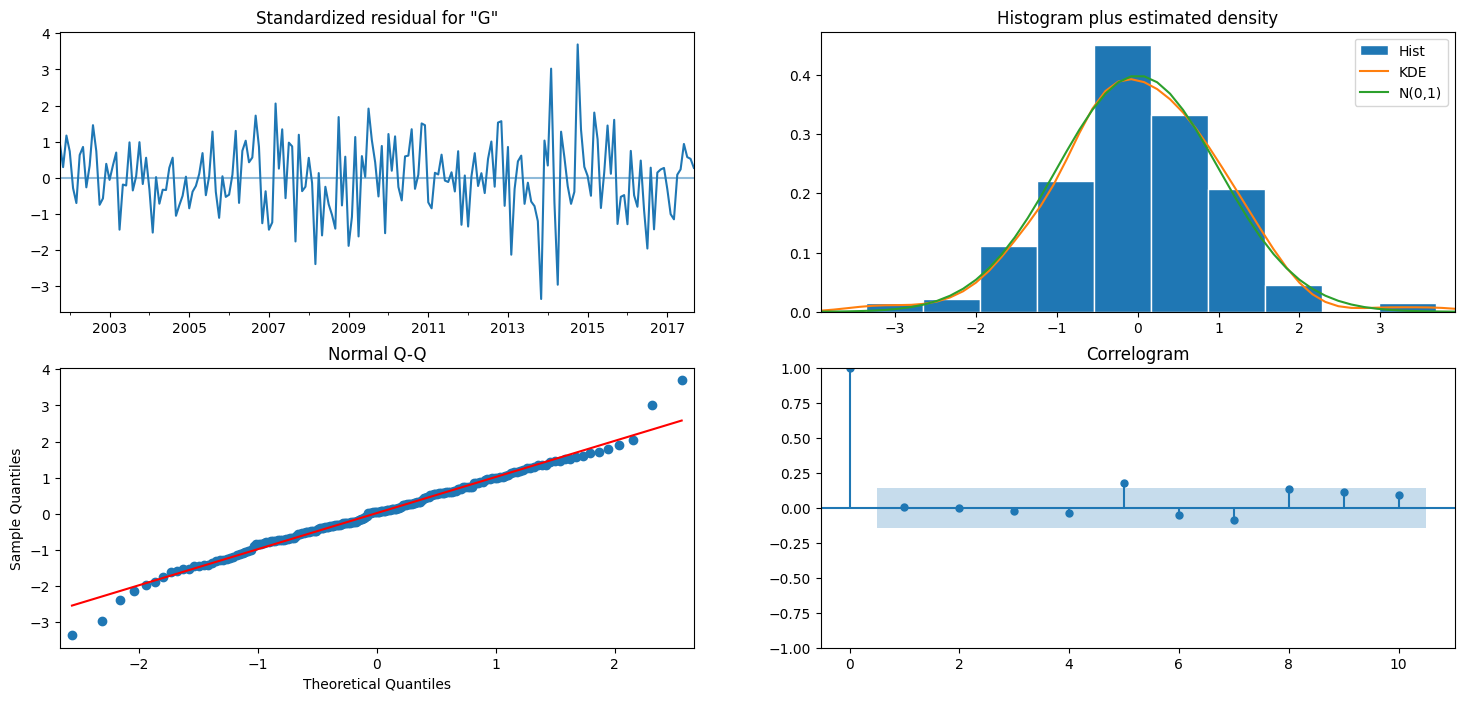

In [28]:
resultado_m211.plot_diagnostics(figsize=(18, 8))
plt.show()

In [29]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 110=",resultado_m110.aic)
print("Modelo 210=",resultado_m210.aic)
print("Modelo 211=",resultado_m211.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 110=",resultado_m110.bic)
print("Modelo 210=",resultado_m210.bic)
print("Modelo 211=",resultado_m211.bic)

Resultados de AIC (Akaike information criterion)
Modelo 110= -531.0626079230684
Modelo 210= -538.1611430426844
Modelo 211= -544.8981136359446
Resultados de BIC (Bayesian information criterion)
Modelo 110= -518.0118471674489
Modelo 210= -521.8736661825455
Modelo 211= -525.3531414037778


Basado en los parametros el mejor modelo fue el p = 2, d = 1, q = 1.

# ARIMA Gasolina Regular #

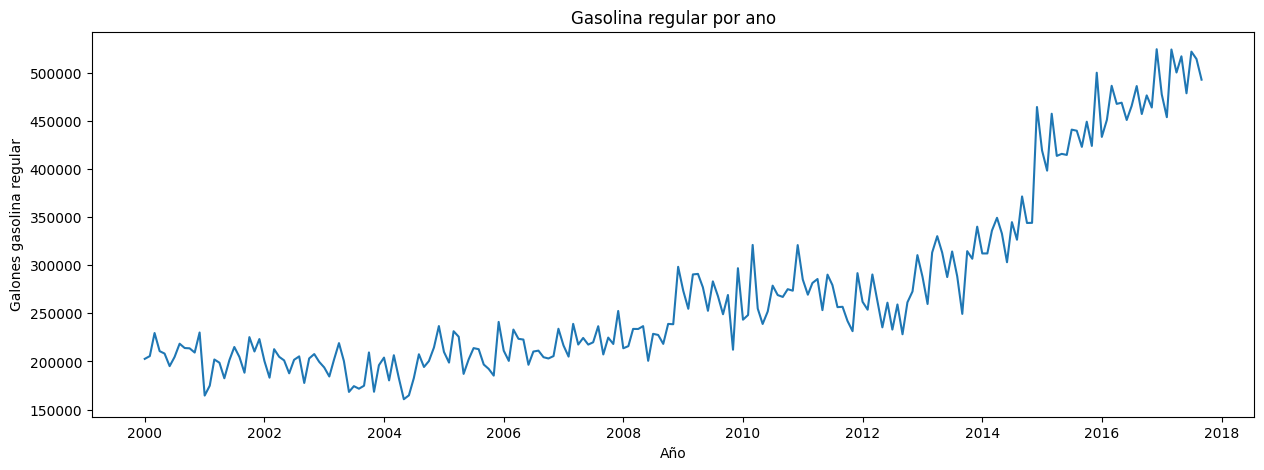

In [30]:
plt.plot(Gasr_df)
plt.gca().set(title="Gasolina regular por ano", xlabel="Año", ylabel="Galones gasolina regular")
plt.show()

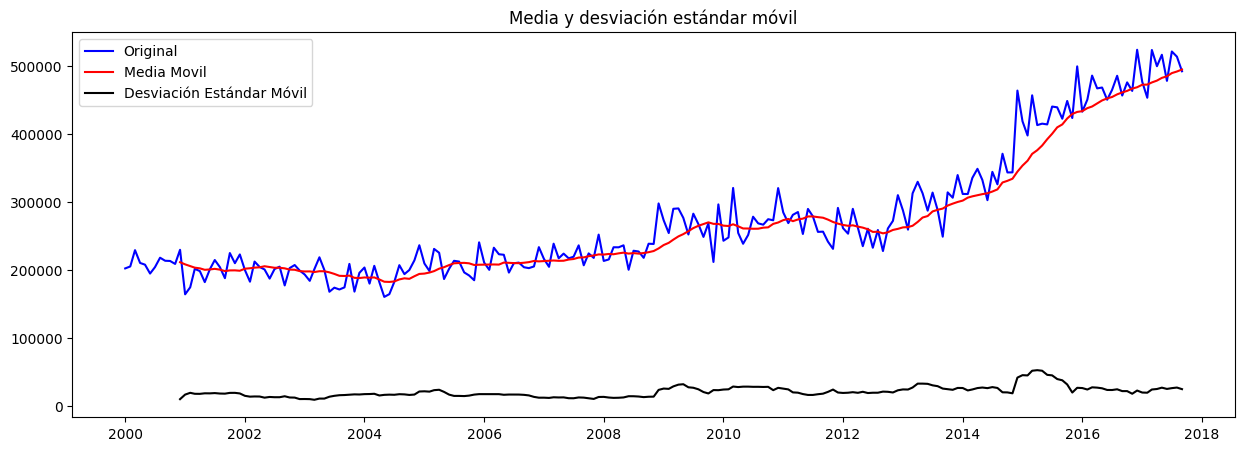

In [31]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = Gasr_df.rolling(window=12).mean()
deMovil = Gasr_df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(Gasr_df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

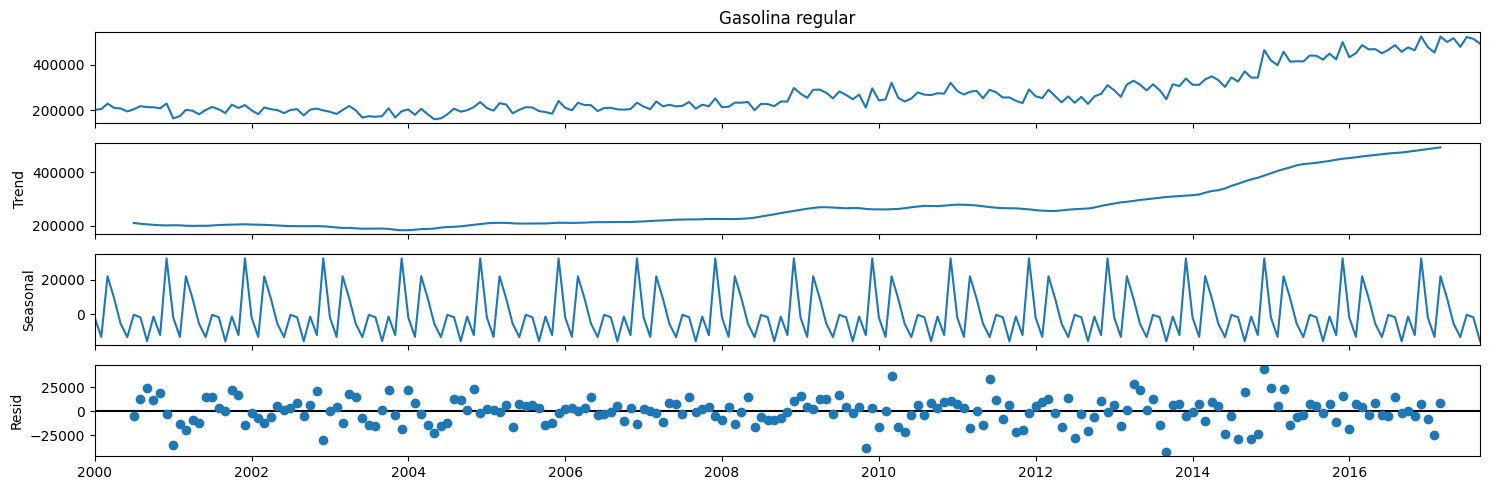

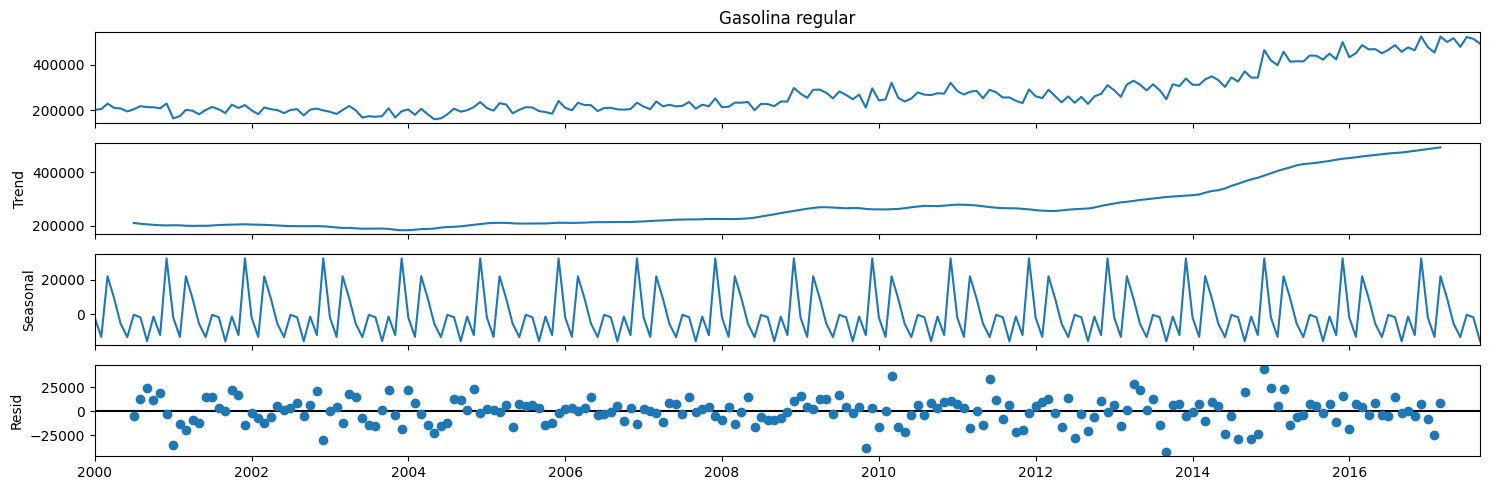

In [32]:
descomposicion = seasonal_decompose(Gasr_df)
descomposicion.plot()

Existe tendencia por lo que no parece ser estacionaria en la media ni en la varianza.

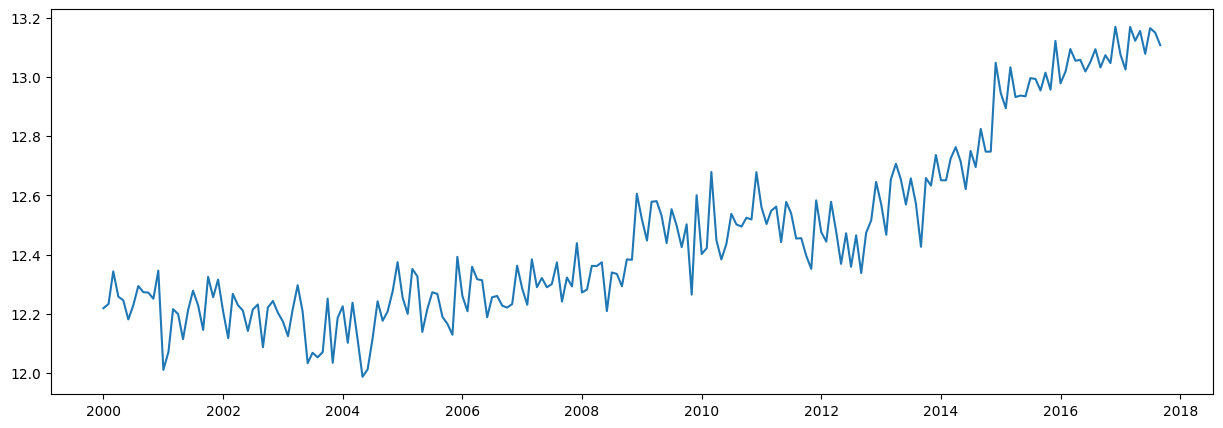

In [33]:
Gasr_df_log = np.log(Gasr_df)
plt.plot(Gasr_df_log)

Con una transformacion logaritmica la serie es estacionaria en la varianza.

In [34]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(Gasr_df, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          1.864621
p-value                        0.998469
# de retardos usados          12.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


No se puede rechazar la hipotesis nula

In [35]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
Gasr_df_diff = Gasr_df.diff()
Gasr_df_diff.dropna(inplace=True)
dfTest = adfuller(Gasr_df_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -3.736255
p-value                        0.003631
# de retardos usados          12.000000
# de observaciones usadas    199.000000
Critical Value (1%)           -3.463645
Critical Value (5%)           -2.876176
Critical Value (10%)          -2.574572
dtype: float64


El valor p es menor que 0.05 por lo que se rechaza la hipotesis nula por lo que no hay raices unitarias y se estacionarizo la serie en la media con una diferenciacion.

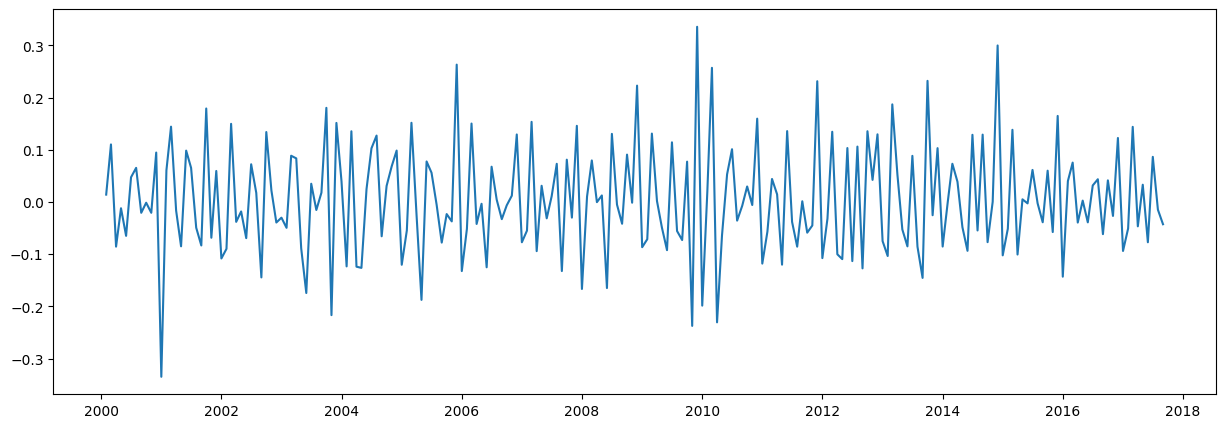

In [36]:
plt.plot(Gasr_df_log.diff())

In [37]:
Gasr_df_log_diff = Gasr_df_log.diff()
Gasr_df_log_diff.dropna(inplace = True)
tsa_acf = acf(Gasr_df_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(Gasr_df_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.42724195, -0.15236516,  0.15540517, -0.04492738,
        0.13959872])

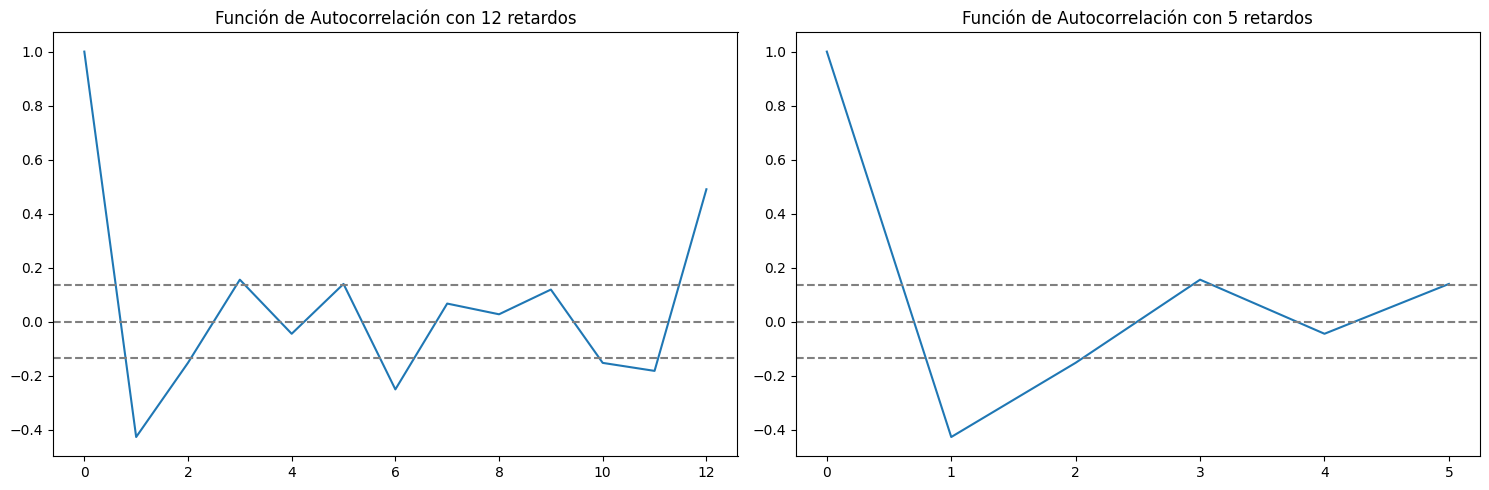

In [38]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(Gasr_df_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(Gasr_df_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

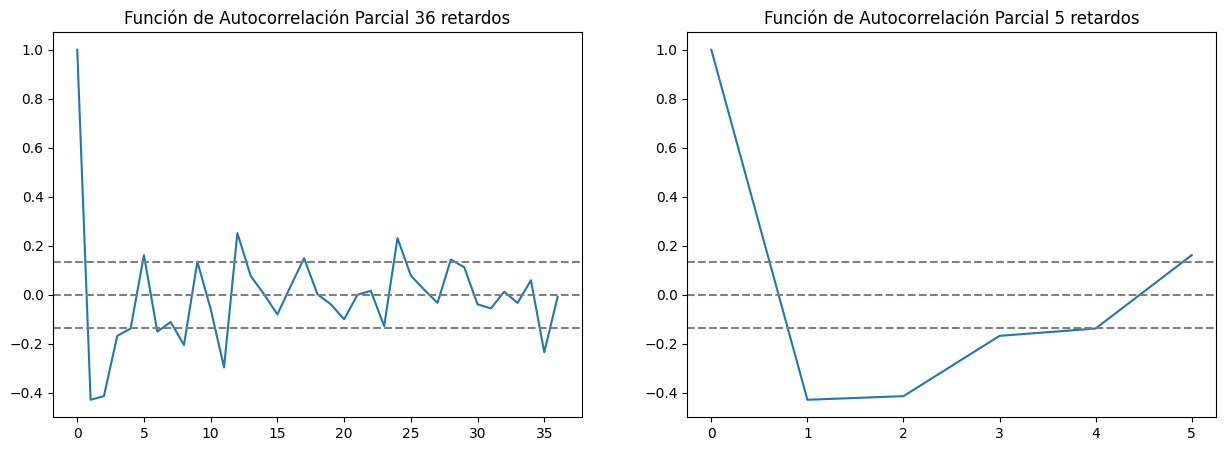

In [39]:
plt.subplot(121)
plt.plot(pacf(Gasr_df_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(Gasr_df_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Estacionalidad

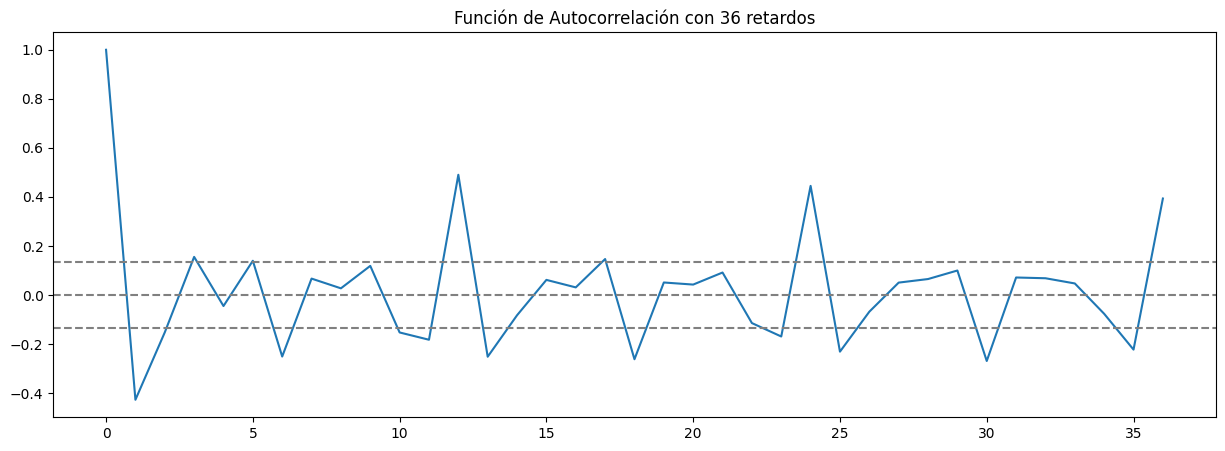

In [40]:
plt.plot(acf(Gasr_df_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Parece haber estacionalidad cada 12 meses

In [41]:
Gasr_df_log_D = Gasr_df_log.diff(12)
Gasr_df_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

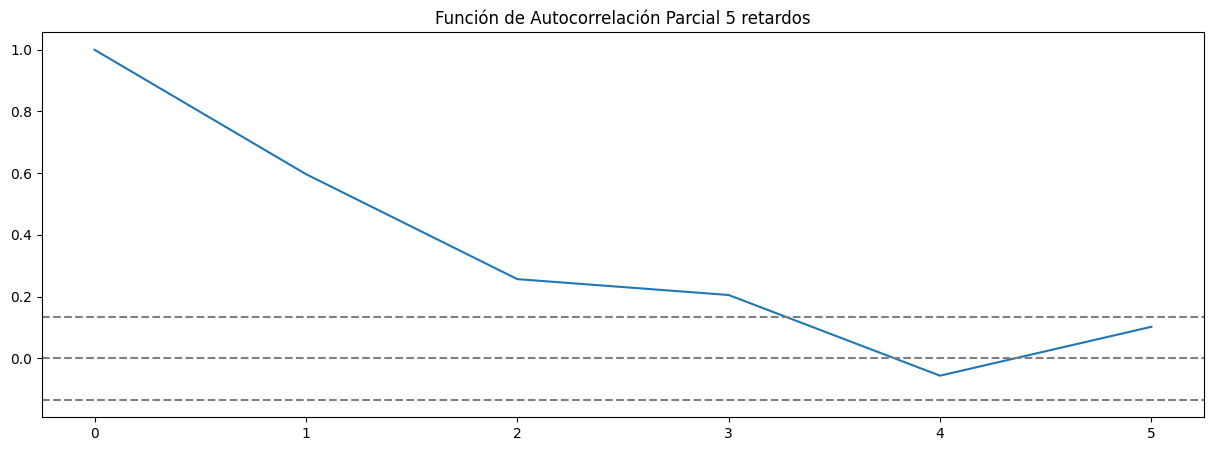

In [42]:
plt.plot(pacf(Gasr_df_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

Despues de p = 3 practicamente se anulan los coeficientes

In [43]:
modelo110 = SARIMAX(Gasr_df_log, order=(1,1,0), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m110 = modelo110.fit()
print(resultado_m110.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4366      0.069     -6.354      0.000      -0.571      -0.302
ar.S.L12      -0.7176      0.063    -11.369      0.000      -0.841      -0.594
ar.S.L24      -0.4912      0.088     -5.581      0.000      -0.664      -0.319
ar.S.L36      -0.2962      0.078     -3.789      0.000      -0.449      -0.143
sigma2         0.0052      0.001      9.078      0.000       0.004       0.006


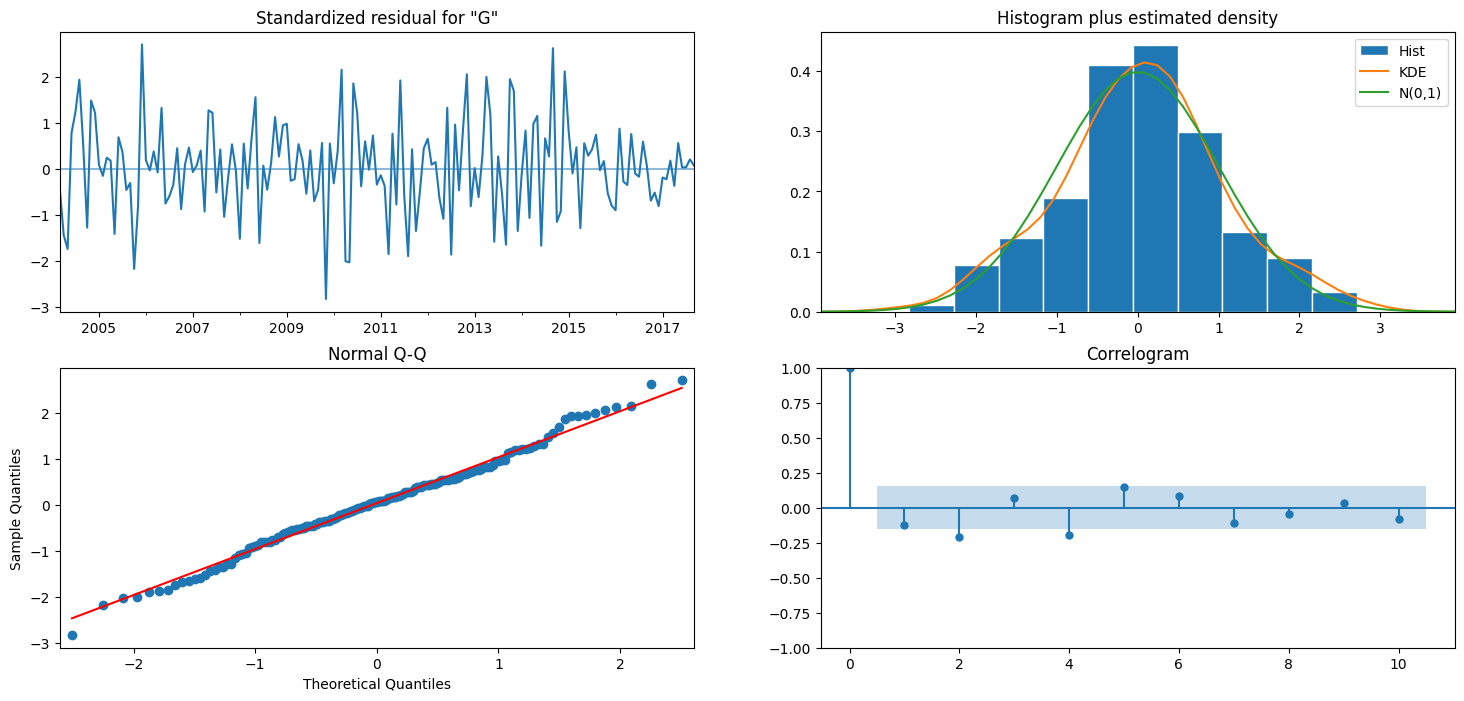

In [44]:
resultado_m110.plot_diagnostics(figsize=(18, 8))
plt.show()

In [45]:
modelo210 = SARIMAX(Gasr_df_log, order=(2,1,0), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m210 = modelo210.fit()
print(resultado_m210.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5619      0.074     -7.567      0.000      -0.707      -0.416
ar.L2         -0.2765      0.074     -3.760      0.000      -0.421      -0.132
ar.S.L12      -0.7377      0.068    -10.859      0.000      -0.871      -0.605
ar.S.L24      -0.4963      0.093     -5.328      0.000      -0.679      -0.314
ar.S.L36      -0.3085      0.083     -3.711      0.000      -0.471      -0.146
sigma2         0.0048      0.001      8.652      0.000       0.004       0.006


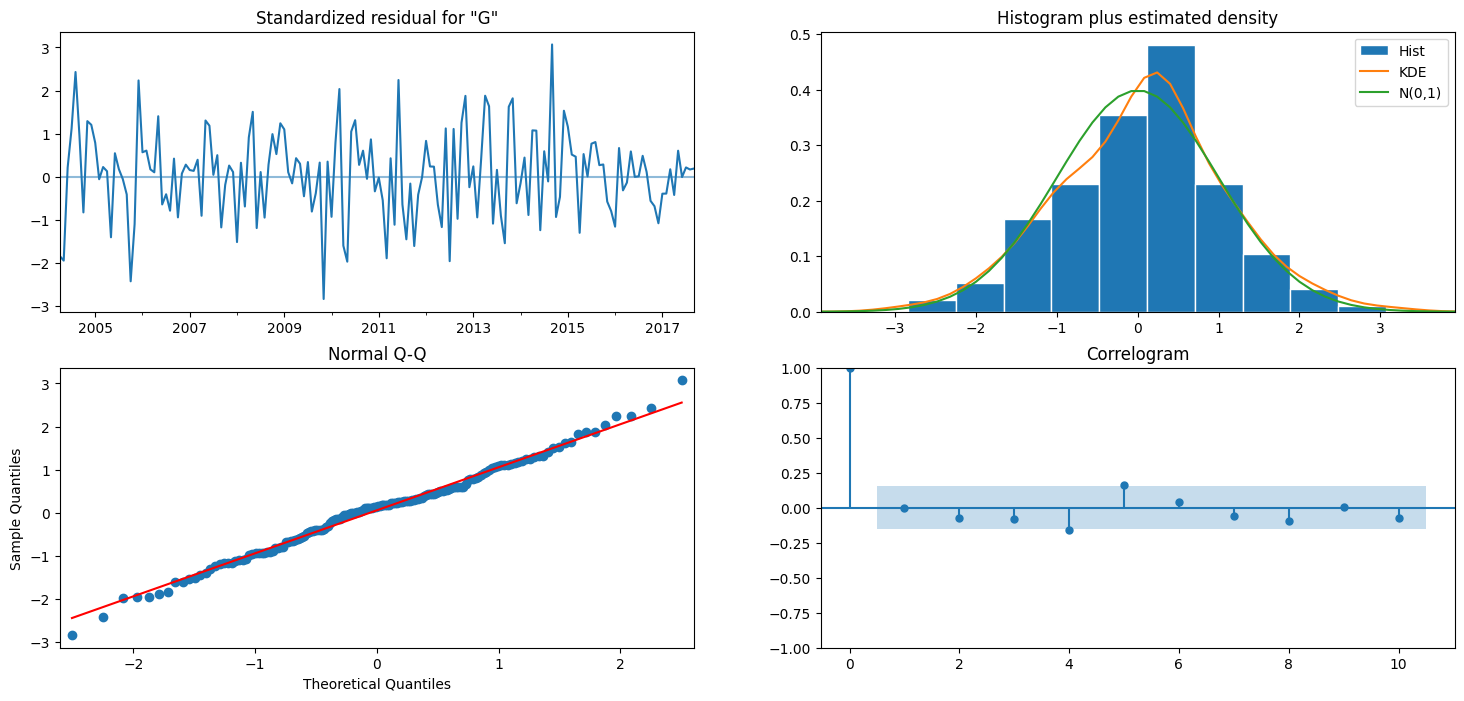

In [46]:
resultado_m210.plot_diagnostics(figsize=(18, 8))
plt.show()

In [47]:
modelo310 = SARIMAX(Gasr_df_log, order=(3,1,0), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m310 = modelo310.fit()
print(resultado_m310.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5573      0.076     -7.303      0.000      -0.707      -0.408
ar.L2         -0.2720      0.088     -3.085      0.002      -0.445      -0.099
ar.L3          0.0317      0.073      0.437      0.662      -0.111       0.174
ar.S.L12      -0.7281      0.068    -10.741      0.000      -0.861      -0.595
ar.S.L24      -0.4926      0.092     -5.327      0.000      -0.674      -0.311
ar.S.L36      -0.2969      0.083     -3.567      0.000      -0.460      -0.134
sigma2         0.0047      0.001      8.761      0.000       0.004       0.006


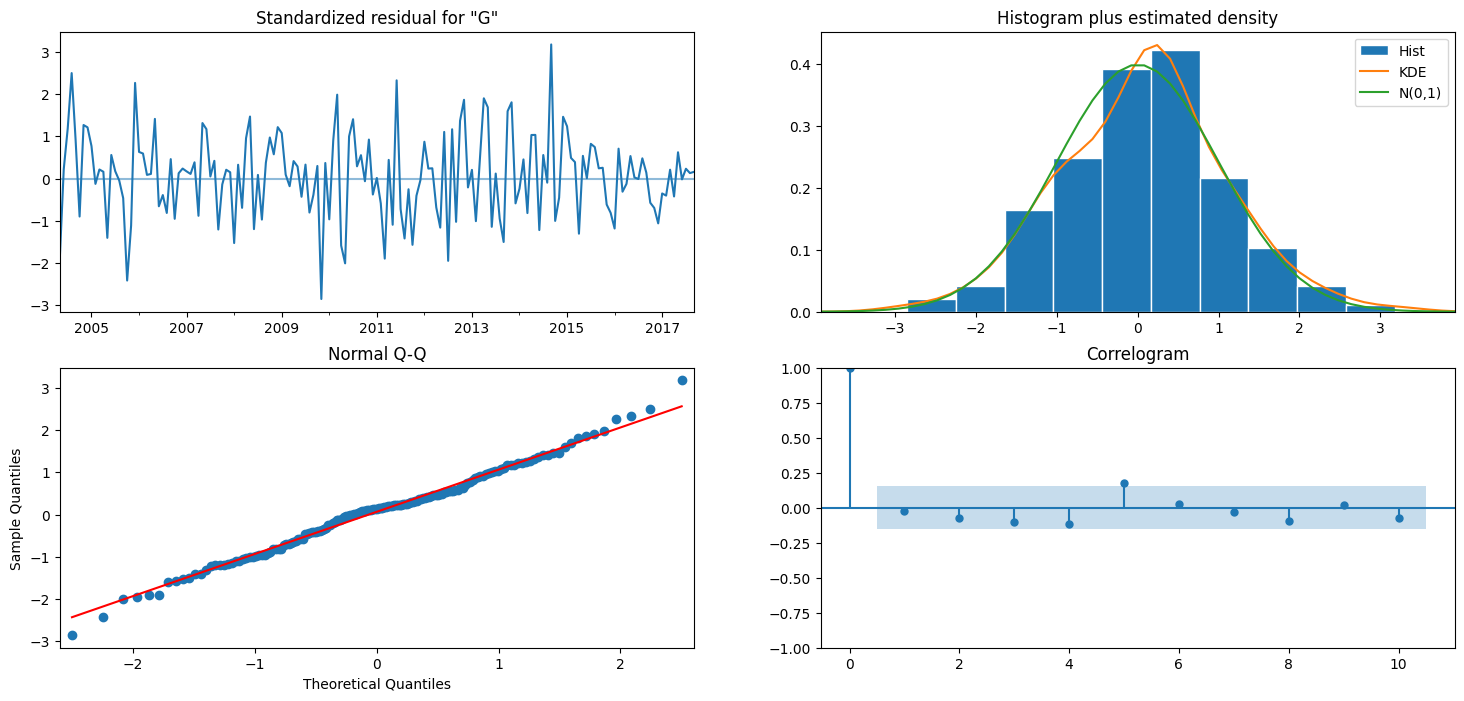

In [48]:
resultado_m310.plot_diagnostics(figsize=(18, 8))
plt.show()

In [49]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 110=",resultado_m110.aic)
print("Modelo 210=",resultado_m210.aic)
print("Modelo 310=",resultado_m310.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 110=",resultado_m110.bic)
print("Modelo 210=",resultado_m210.bic)
print("Modelo 310=",resultado_m310.bic)

Resultados de AIC (Akaike information criterion)
Modelo 110= -385.24984019299296
Modelo 210= -392.9108513514569
Modelo 310= -391.073602978126
Resultados de BIC (Bayesian information criterion)
Modelo 110= -369.78108918895913
Modelo 210= -374.3852733400626
Modelo 310= -369.50377242323475


Basado en los parametros el mejor modelo parece ser p = 2 , d = 1 y q = 0.

# ARIMA Gasolina super #

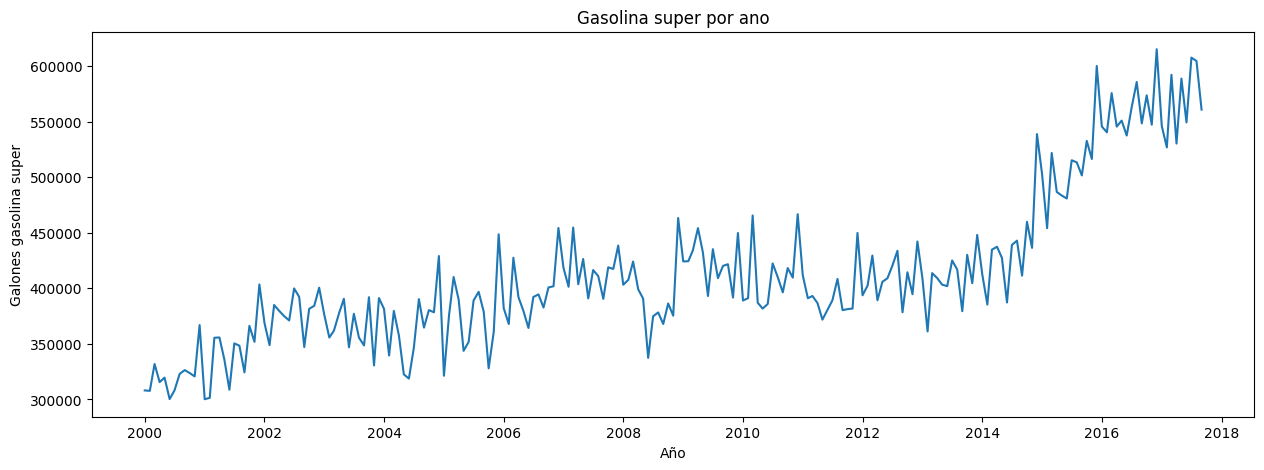

In [50]:
plt.plot(Gass_df)
plt.gca().set(title="Gasolina super por ano", xlabel="Año", ylabel="Galones gasolina super")
plt.show()

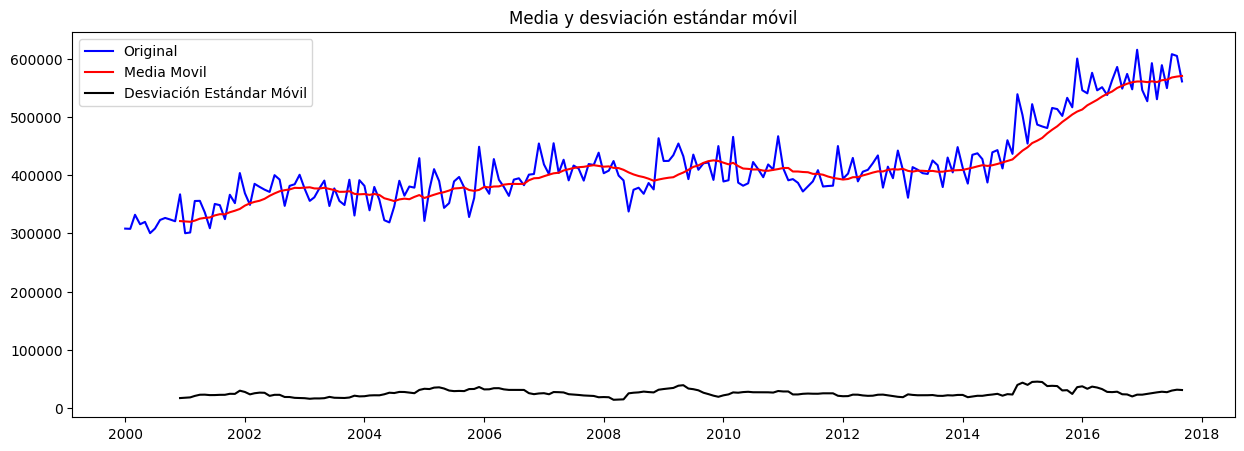

In [51]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = Gass_df.rolling(window=12).mean()
deMovil = Gass_df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(Gass_df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

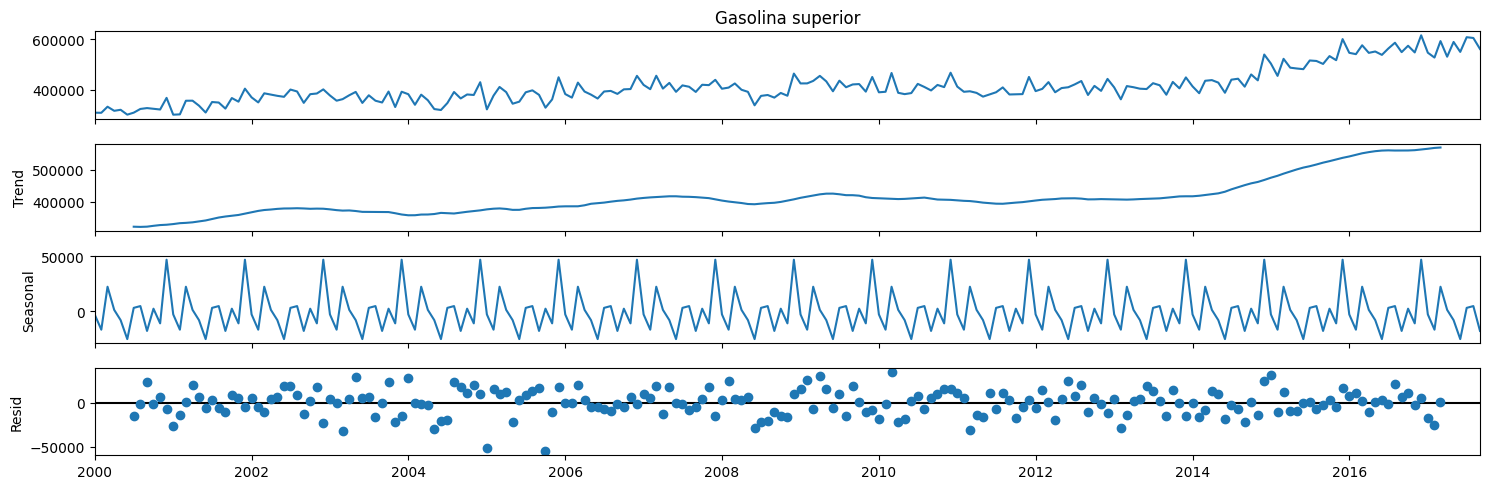

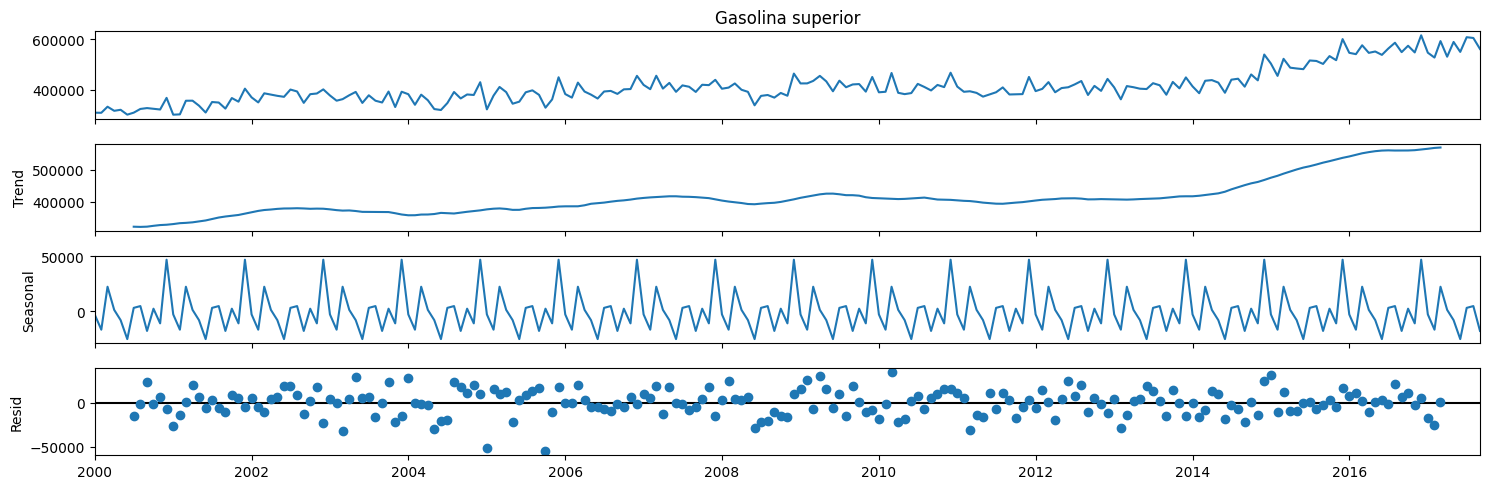

In [52]:
descomposicion = seasonal_decompose(Gass_df)
descomposicion.plot()

Existe tendencia por lo que no parece ser estacionaria en la media ni en la varianza.

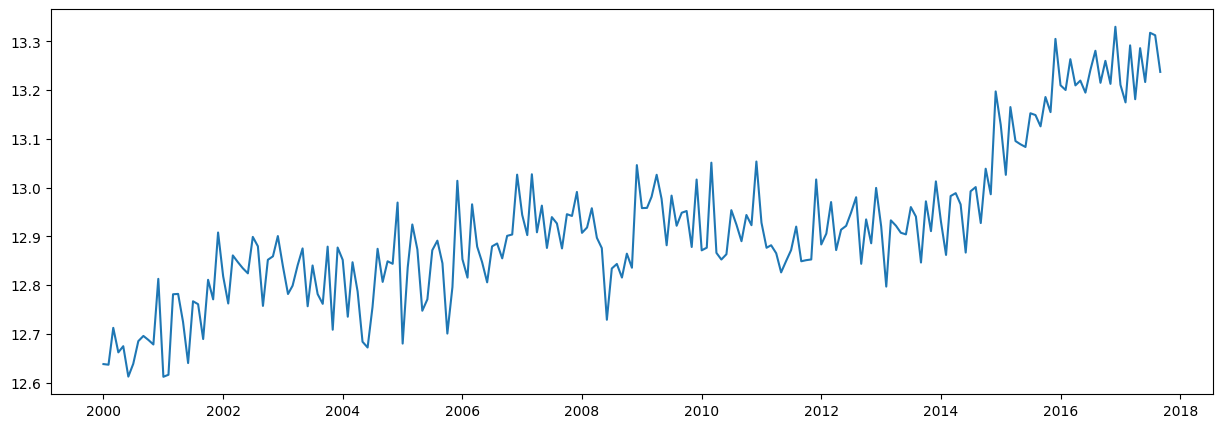

In [53]:
Gass_df_log = np.log(Gass_df)
plt.plot(Gass_df_log)

Con una transformacion logaritmica la serie es estacionaria en la varianza.

In [54]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(Gass_df, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.486218
p-value                        0.984448
# de retardos usados          12.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


No se puede rechazar la hipotesis nula.

In [55]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
Gass_df_diff = Gass_df.diff()
Gass_df_diff.dropna(inplace=True)
dfTest = adfuller(Gass_df_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.511038
p-value                        0.000188
# de retardos usados          11.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


El valor p es menor que 0.05 por lo que se rechaza la hipotesis nula por lo que no hay raices unitarias y se estacionarizo la serie en la media con una diferenciacion.

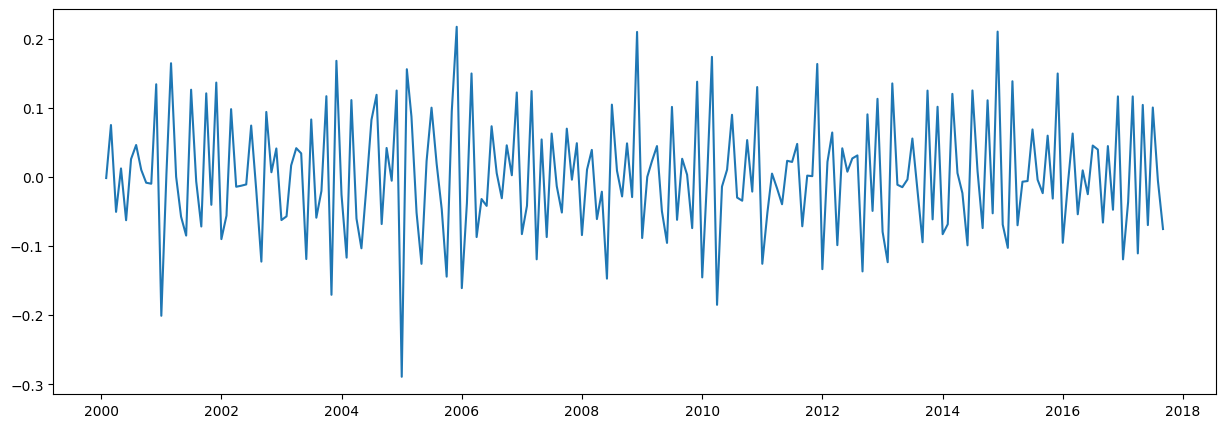

In [56]:
plt.plot(Gass_df_log.diff())

In [57]:
Gass_df_log_diff = Gass_df_log.diff()
Gass_df_log_diff.dropna(inplace = True)
tsa_acf = acf(Gass_df_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(Gass_df_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.45890201, -0.12541113,  0.1005634 , -0.00360539,
        0.2421749 ])

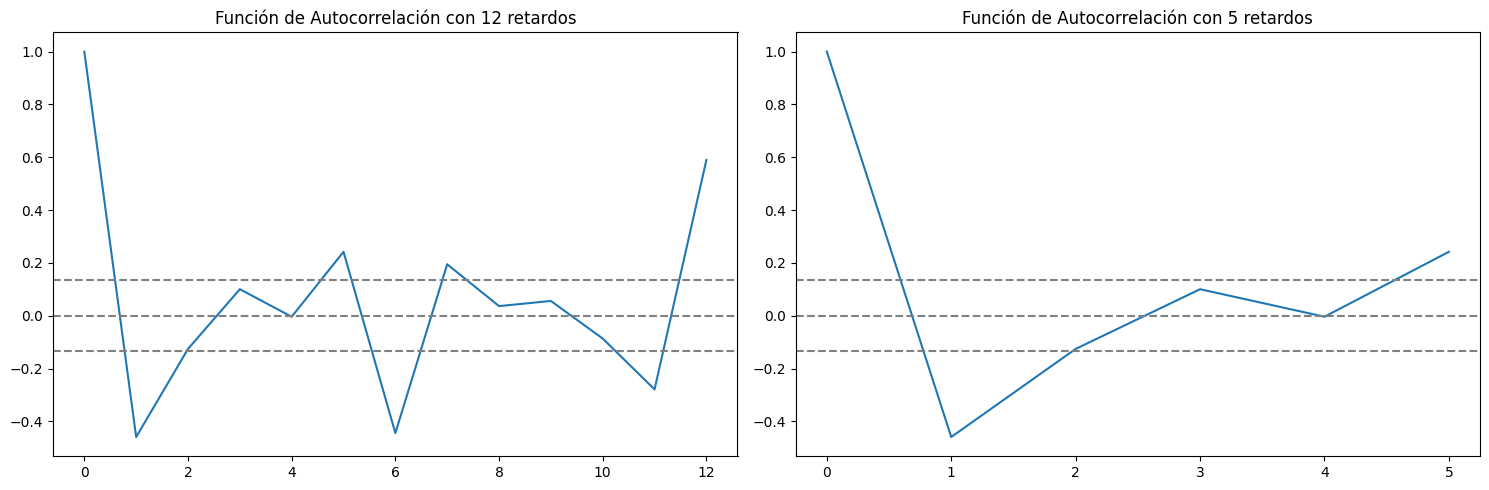

In [58]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(Gass_df_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(Gass_df_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

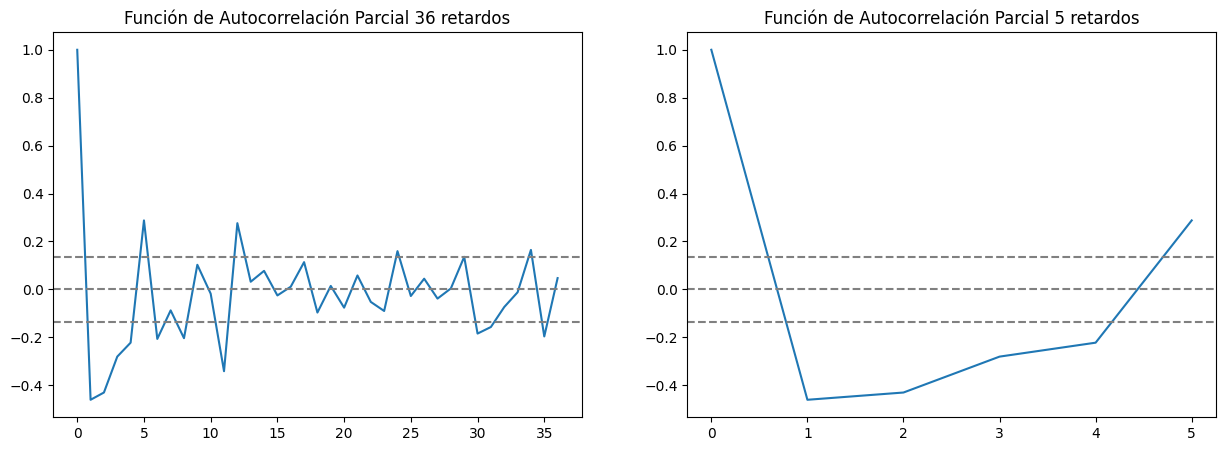

In [59]:
plt.subplot(121)
plt.plot(pacf(Gass_df_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(Gass_df_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Estacionalidad

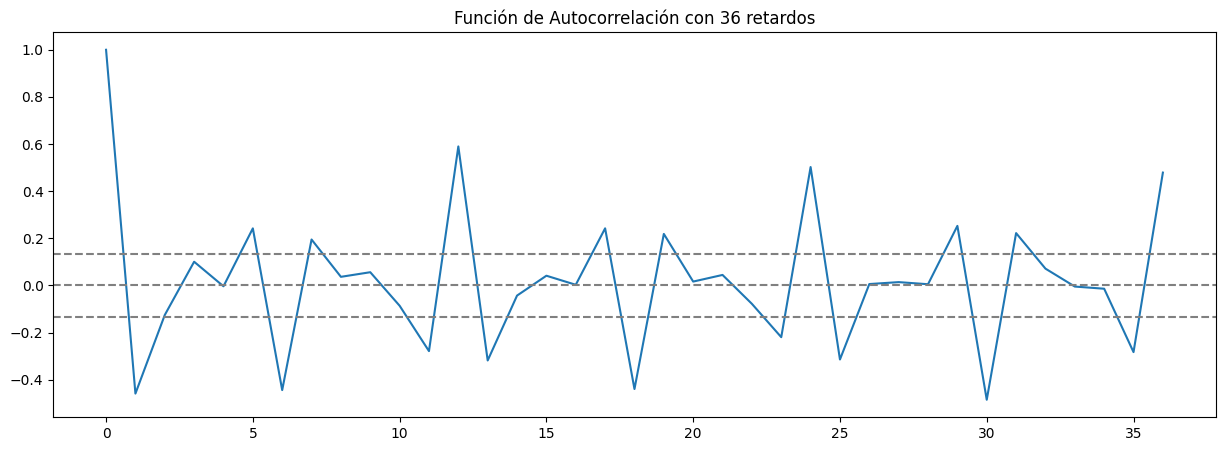

In [60]:
plt.plot(acf(Gass_df_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Parece haber estacionalidad cada 12 meses

In [61]:
Gass_df_log_D = Gass_df_log.diff(12)
Gass_df_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

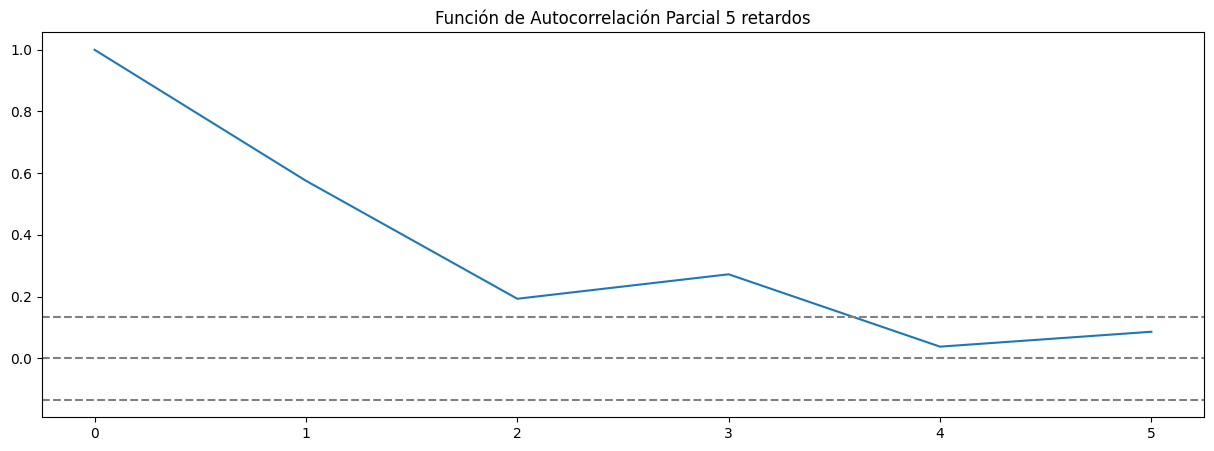

In [62]:
plt.plot(pacf(Gass_df_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

Despues de p = 3 practicamente se anulan los coeficientes

In [63]:
modelo110 = SARIMAX(Gass_df_log, order=(1,1,0), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m110 = modelo110.fit()
print(resultado_m110.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3857      0.066     -5.839      0.000      -0.515      -0.256
ar.S.L12      -0.6857      0.064    -10.735      0.000      -0.811      -0.561
ar.S.L24      -0.5384      0.088     -6.117      0.000      -0.711      -0.366
ar.S.L36      -0.3173      0.064     -4.920      0.000      -0.444      -0.191
sigma2         0.0031      0.000     12.218      0.000       0.003       0.004


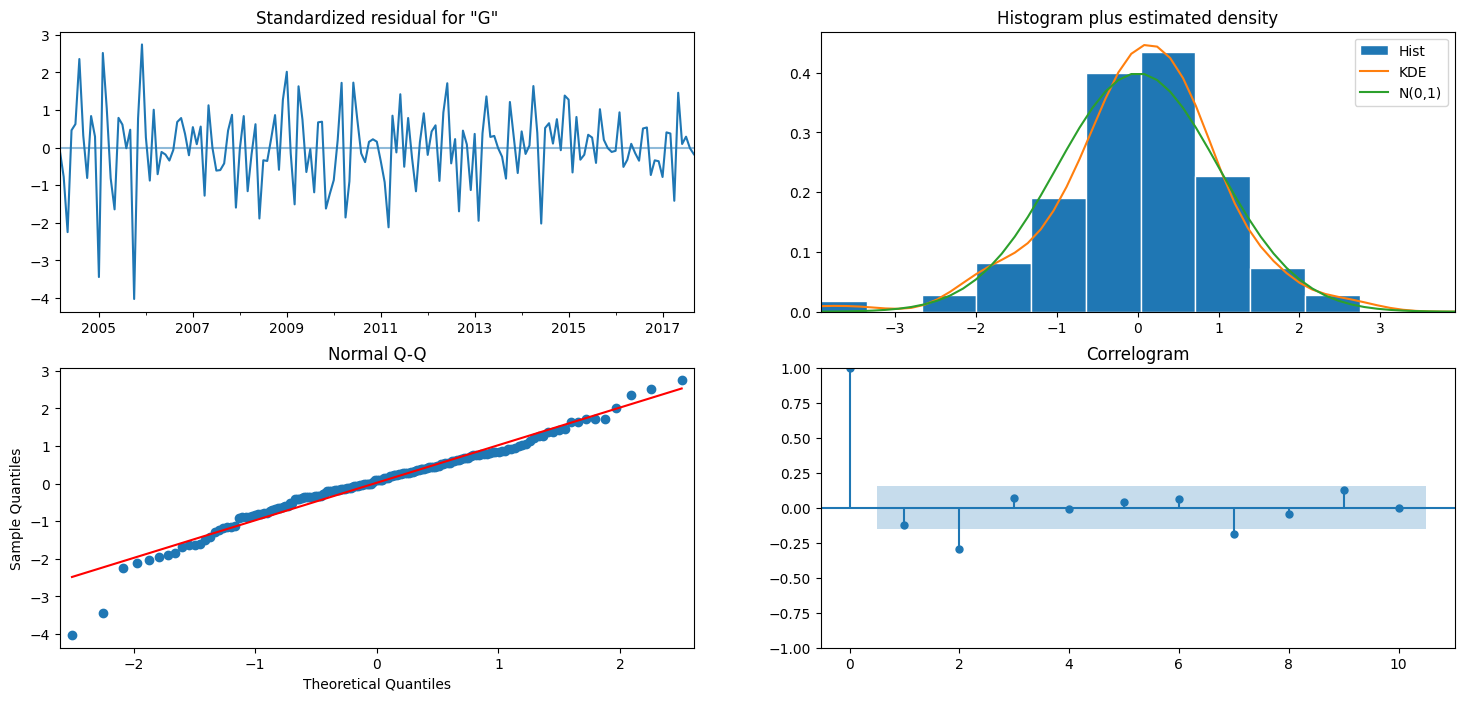

In [64]:
resultado_m110.plot_diagnostics(figsize=(18, 8))
plt.show()

In [65]:
modelo210 = SARIMAX(Gass_df_log, order=(2,1,0), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m210 = modelo210.fit()
print(resultado_m210.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5134      0.079     -6.486      0.000      -0.669      -0.358
ar.L2         -0.3201      0.075     -4.243      0.000      -0.468      -0.172
ar.S.L12      -0.7072      0.069    -10.226      0.000      -0.843      -0.572
ar.S.L24      -0.5491      0.100     -5.468      0.000      -0.746      -0.352
ar.S.L36      -0.3100      0.066     -4.686      0.000      -0.440      -0.180
sigma2         0.0028      0.000     12.132      0.000       0.002       0.003


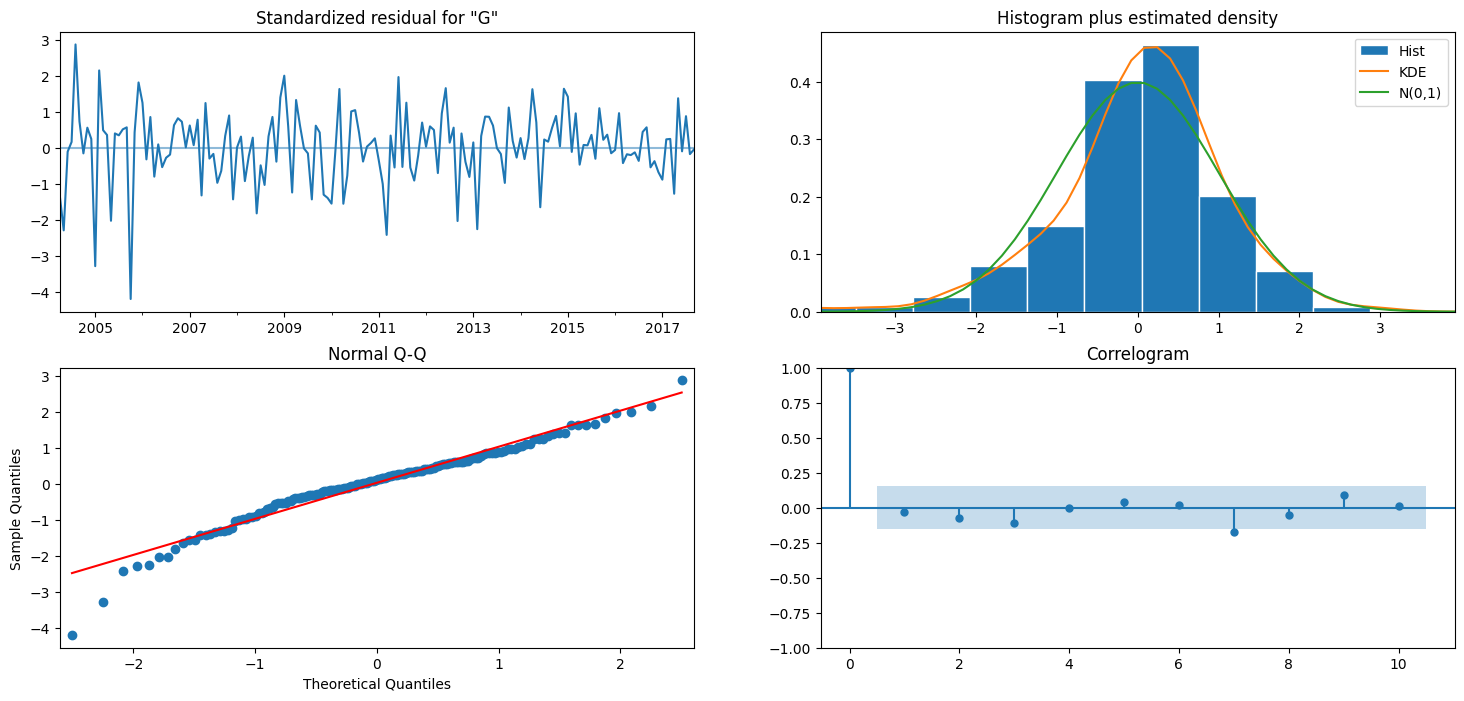

In [66]:
resultado_m210.plot_diagnostics(figsize=(18, 8))
plt.show()

In [67]:
modelo310 = SARIMAX(Gass_df_log, order=(3,1,0), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m310 = modelo310.fit()
print(resultado_m310.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5396      0.089     -6.052      0.000      -0.714      -0.365
ar.L2         -0.3711      0.100     -3.716      0.000      -0.567      -0.175
ar.L3         -0.0762      0.084     -0.905      0.365      -0.241       0.089
ar.S.L12      -0.7018      0.073     -9.588      0.000      -0.845      -0.558
ar.S.L24      -0.5452      0.102     -5.345      0.000      -0.745      -0.345
ar.S.L36      -0.3040      0.067     -4.541      0.000      -0.435      -0.173
sigma2         0.0027      0.000     11.923      0.000       0.002       0.003


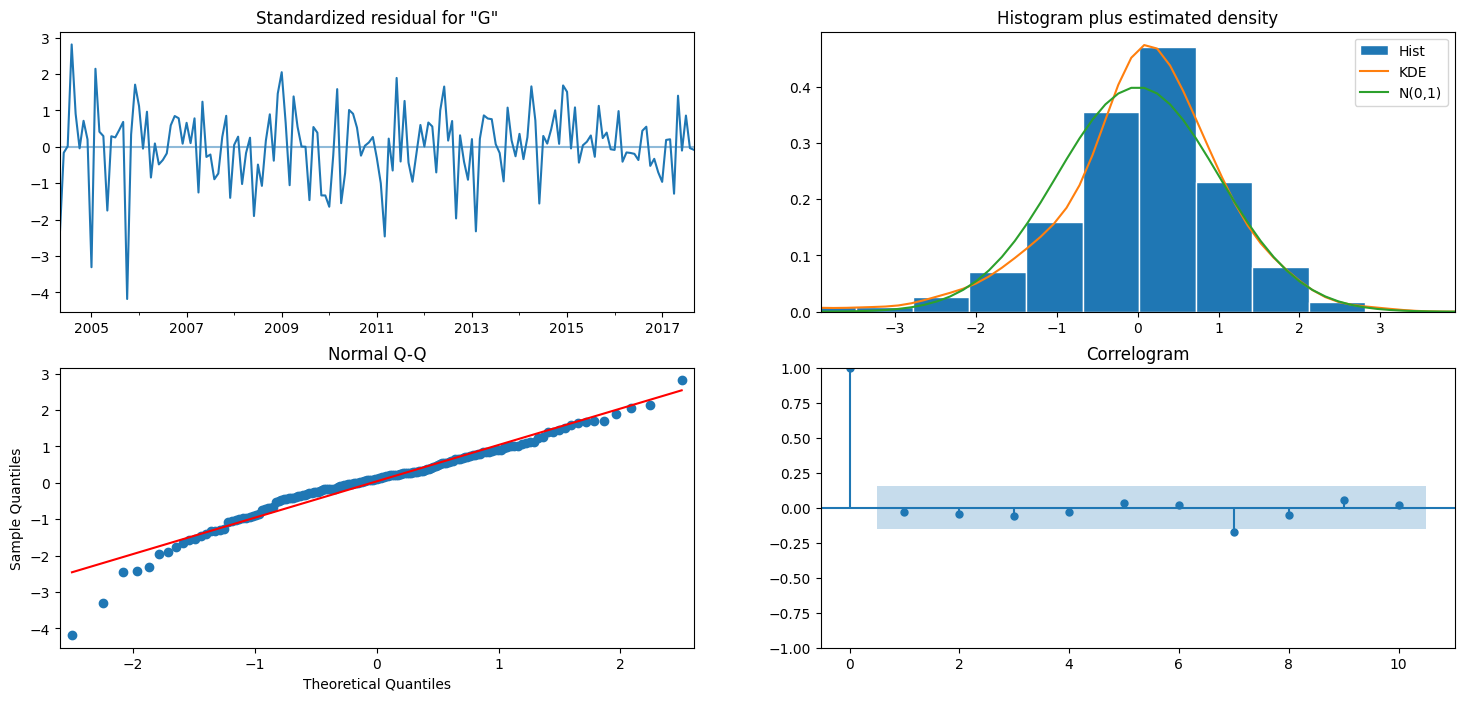

In [68]:
resultado_m310.plot_diagnostics(figsize=(18, 8))
plt.show()

In [69]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 110=",resultado_m110.aic)
print("Modelo 210=",resultado_m210.aic)
print("Modelo 310=",resultado_m310.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 110=",resultado_m110.bic)
print("Modelo 210=",resultado_m210.bic)
print("Modelo 310=",resultado_m310.bic)

Resultados de AIC (Akaike information criterion)
Modelo 110= -469.9810910243686
Modelo 210= -481.7276100392774
Modelo 310= -478.4159058438561
Resultados de BIC (Bayesian information criterion)
Modelo 110= -454.51234002033476
Modelo 210= -463.2020320278831
Modelo 310= -456.8460752889648


El mejor modelo basado en los 2 parametros parece ser el p = 2, d = 1, q = 0.

# ARIMA Diesel #

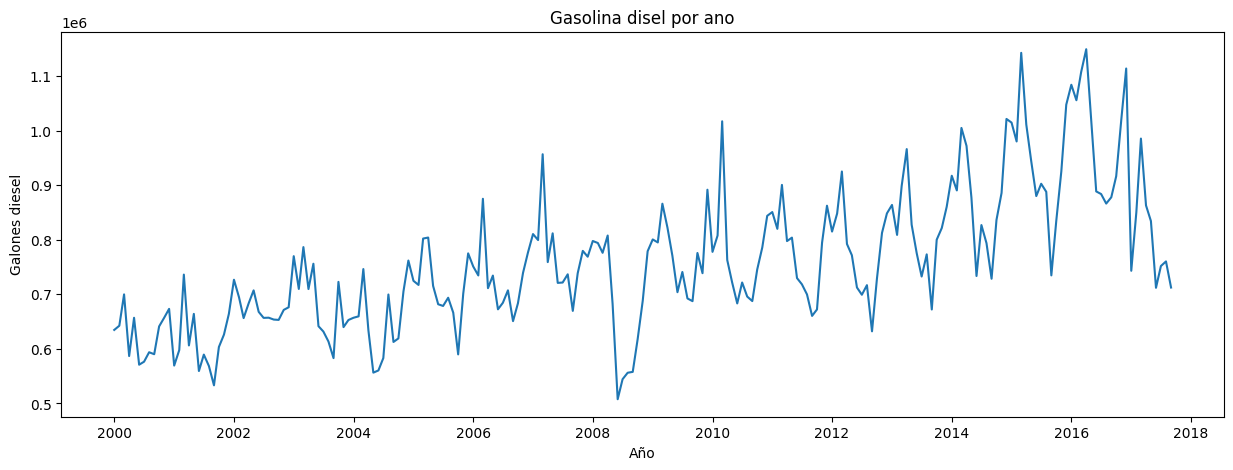

In [70]:
plt.plot(Gasd_df)
plt.gca().set(title="Gasolina disel por ano", xlabel="Año", ylabel="Galones diesel")
plt.show()

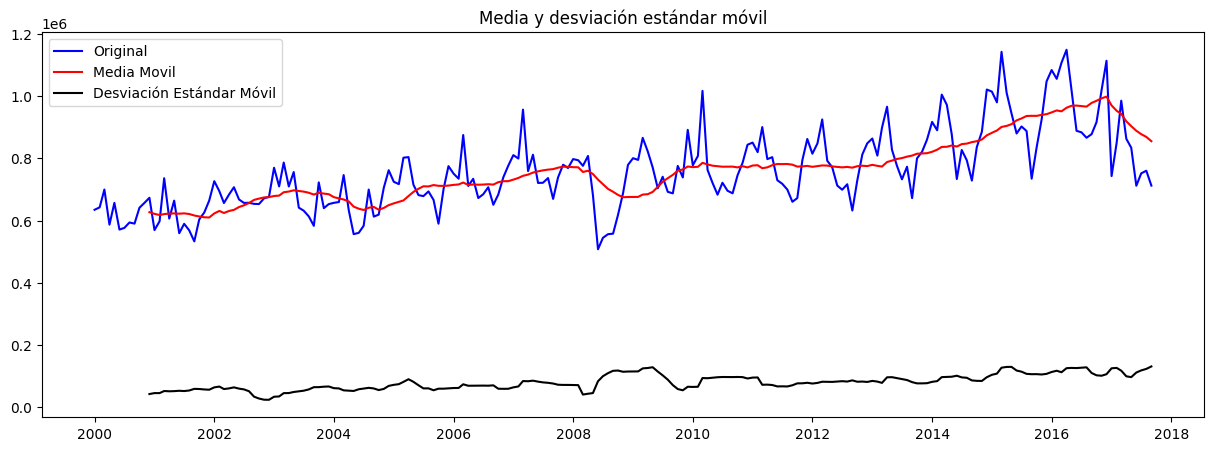

In [71]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = Gasd_df.rolling(window=12).mean()
deMovil = Gasd_df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(Gasd_df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

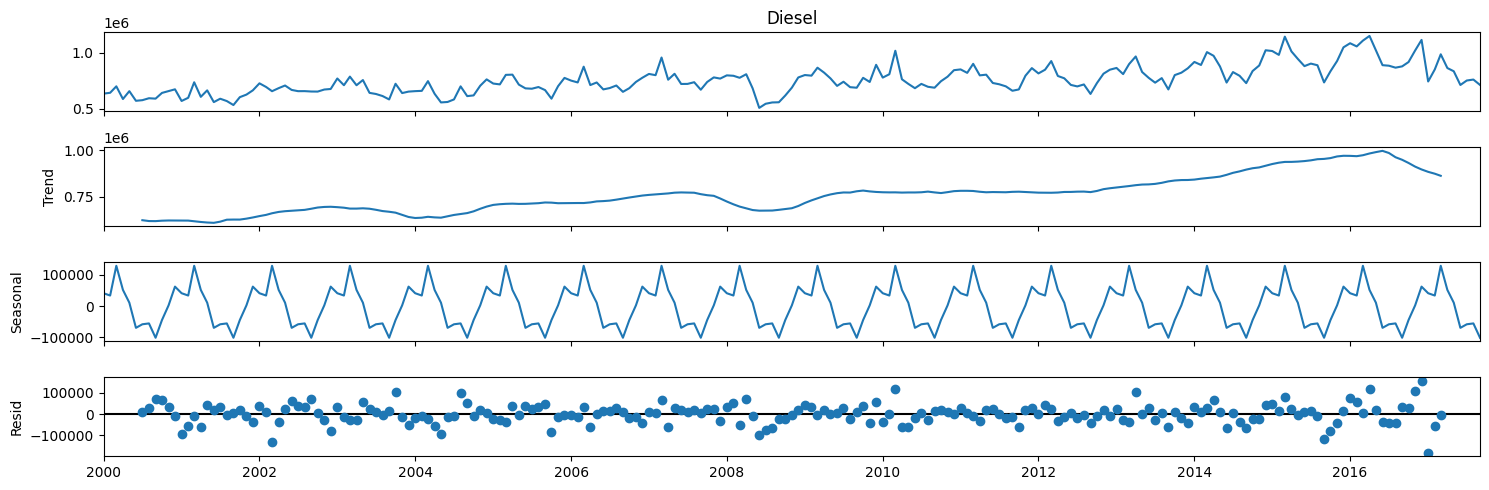

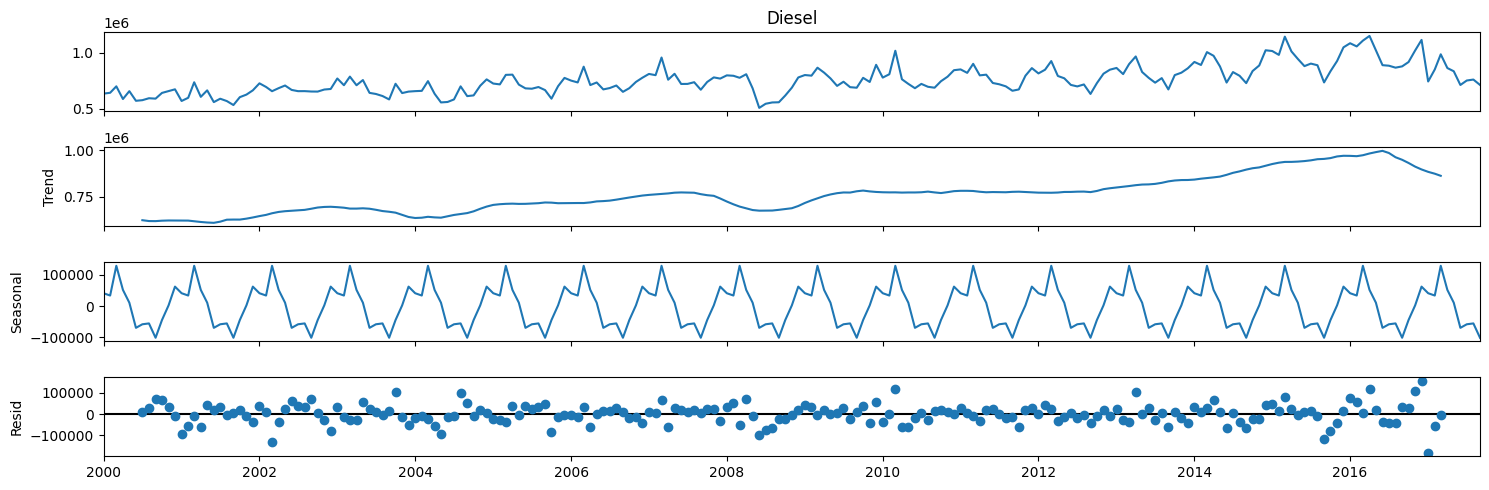

In [72]:
descomposicion = seasonal_decompose(Gasd_df)
descomposicion.plot()

Existe tendencia por lo que no parece ser estacionaria en la media ni en la varianza.

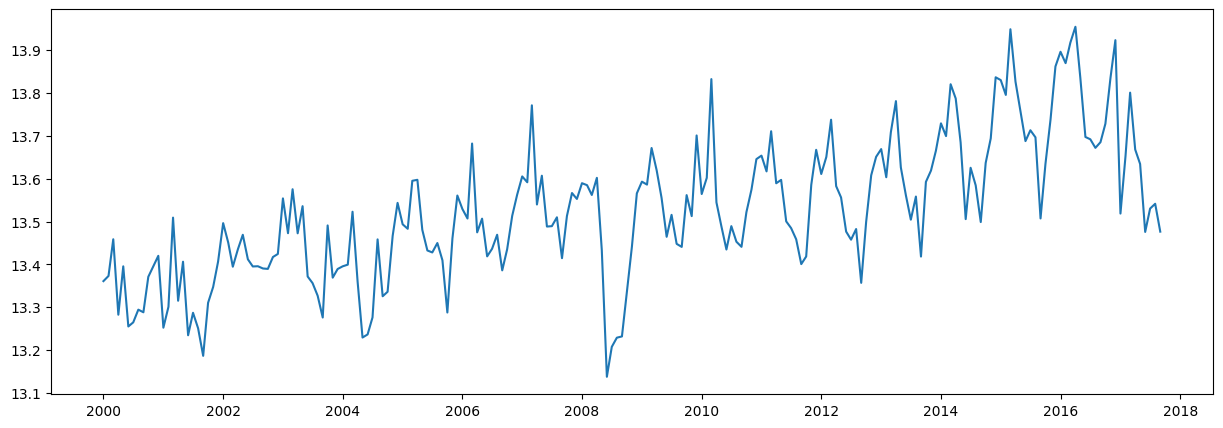

In [73]:
Gasd_df_log = np.log(Gasd_df)
plt.plot(Gasd_df_log)

Con una transformacion logaritmica la serie es estacionaria en la varianza.

In [74]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(Gasd_df, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.777528
p-value                        0.391674
# de retardos usados          14.000000
# de observaciones usadas    198.000000
Critical Value (1%)           -3.463815
Critical Value (5%)           -2.876251
Critical Value (10%)          -2.574611
dtype: float64


No se puede rechazar la hipotesis nula.

In [75]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
Gasd_df_diff = Gasd_df.diff()
Gasd_df_diff.dropna(inplace=True)
dfTest = adfuller(Gasd_df_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -5.391823
p-value                        0.000004
# de retardos usados          11.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


El valor p es menor que 0.05 por lo que se rechaza la hipotesis nula por lo que no hay raices unitarias y se estacionarizo la serie en la media con una diferenciacion.

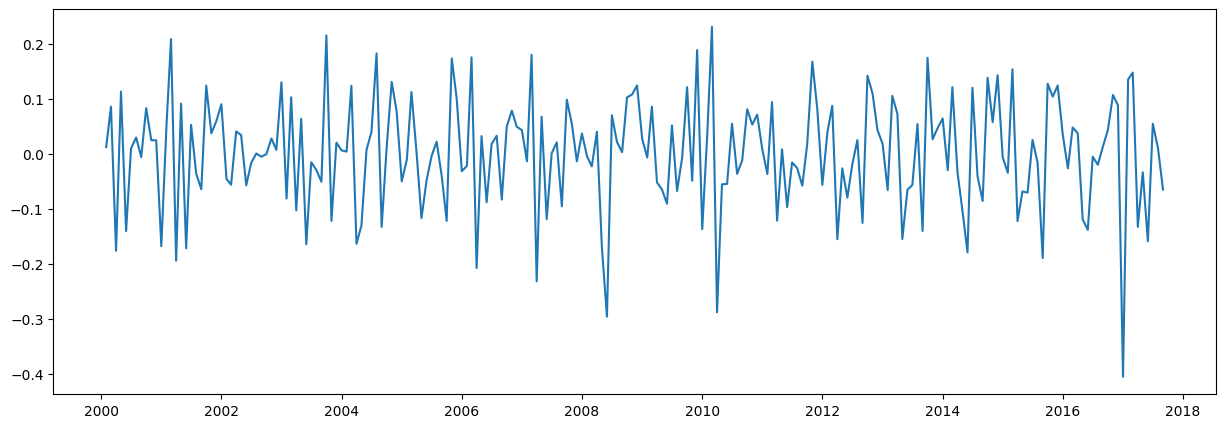

In [76]:
plt.plot(Gasd_df_log.diff())

In [77]:
Gasd_df_log_diff = Gasd_df_log.diff()
Gasd_df_log_diff.dropna(inplace = True)
tsa_acf = acf(Gasd_df_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(Gasd_df_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.22454957, -0.03495529,  0.04155913, -0.07013212,
        0.07323833])

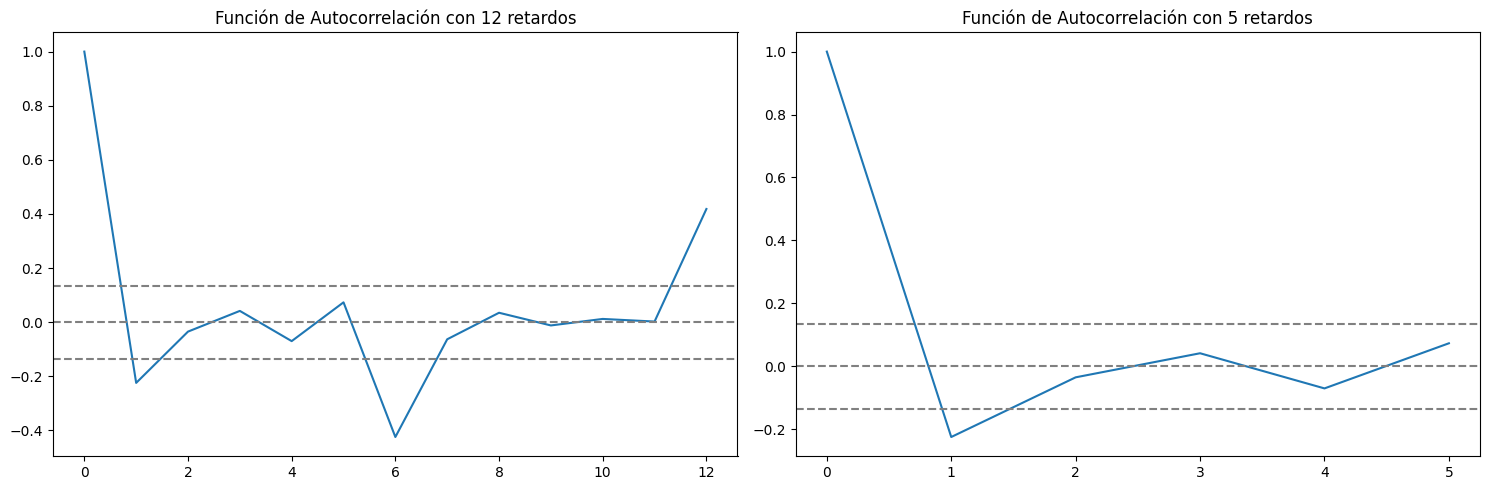

In [78]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(Gasd_df_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(Gasd_df_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

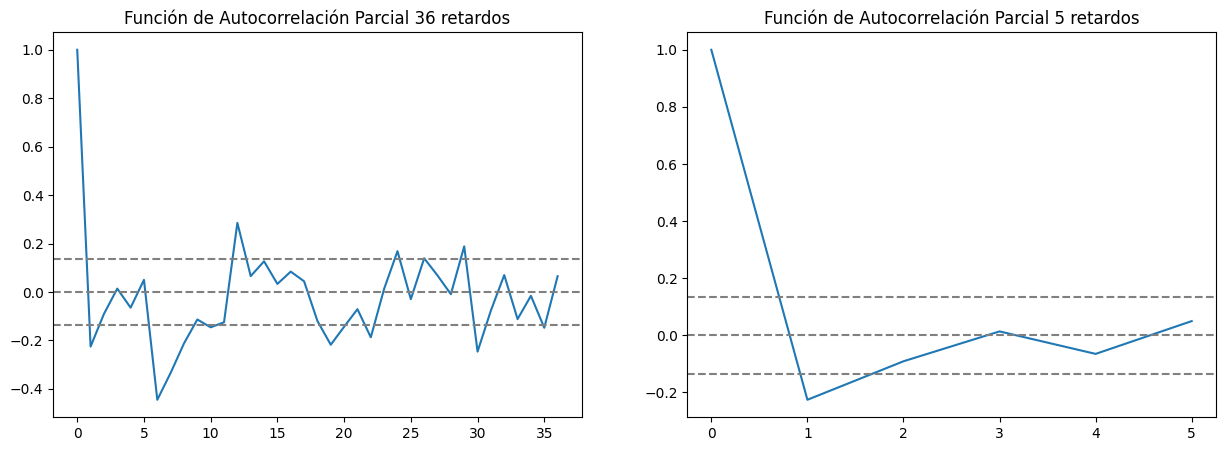

In [79]:
plt.subplot(121)
plt.plot(pacf(Gasd_df_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(Gasd_df_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Estacionalidad

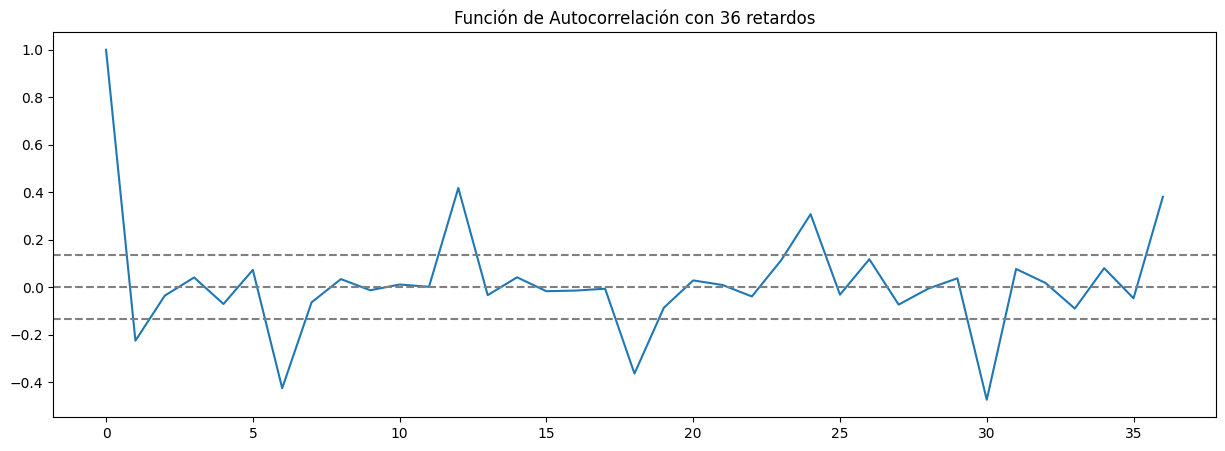

In [80]:
plt.plot(acf(Gasd_df_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

No parece haber una estacionalidad clara.

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 10 retardos')

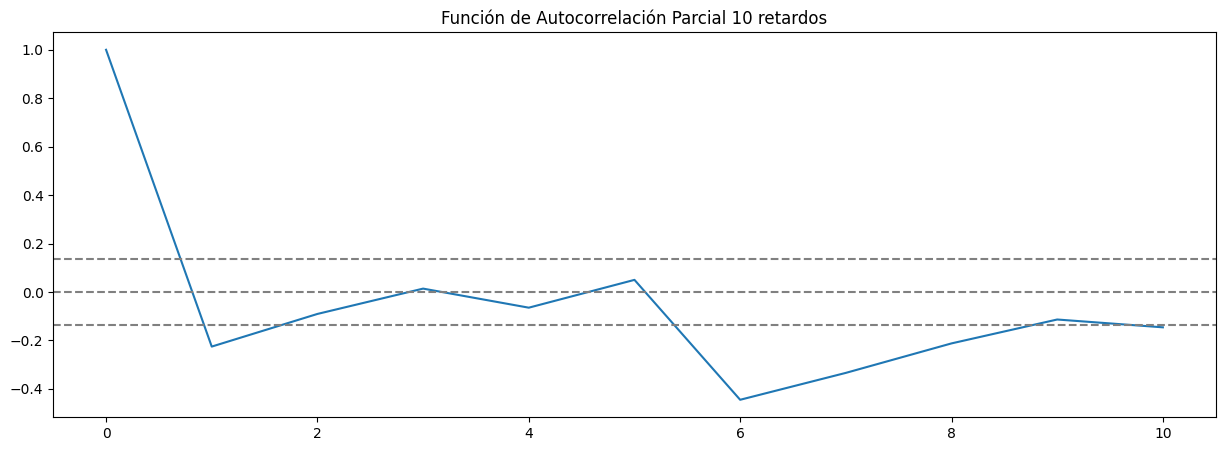

In [81]:
plt.plot(pacf(Gasd_df_log_diff, nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 10 retardos')

Despues de p = 0, salvo por p = 5 se anulan los coeficientes

In [82]:
modelo010 = SARIMAX(Gasd_df_log, order=(0,1,0), enforce_stationarity=False, enforce_invertibility=False)
resultado_m010 = modelo010.fit()
print(resultado_m010.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0102      0.001     12.099      0.000       0.009       0.012


c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


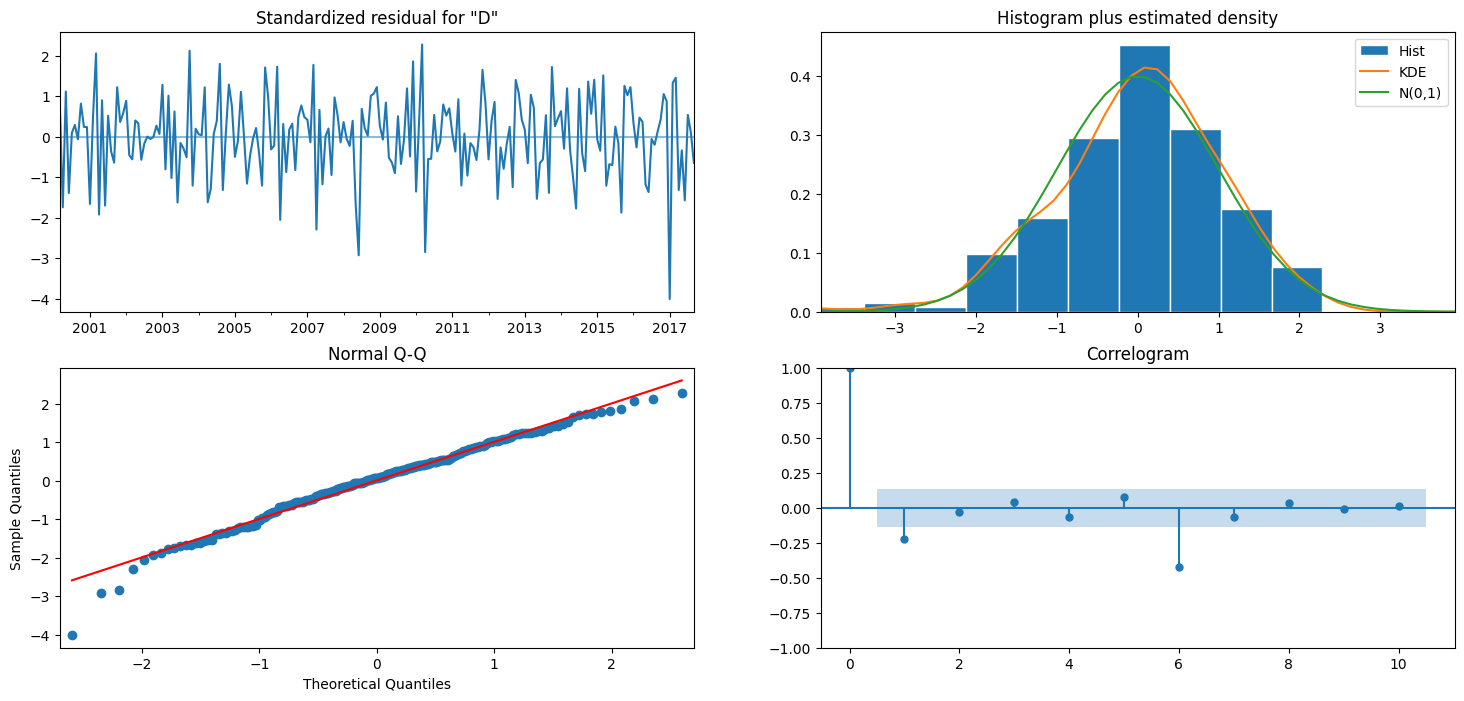

In [83]:

resultado_m010.plot_diagnostics(figsize=(18, 8))
plt.show()

In [84]:
modelo510 = SARIMAX(Gasd_df_log, order=(5,1,0), enforce_stationarity=False, enforce_invertibility=False)
resultado_m510 = modelo510.fit()
print(resultado_m510.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2222      0.068     -3.263      0.001      -0.356      -0.089
ar.L2         -0.1004      0.084     -1.196      0.232      -0.265       0.064
ar.L3          0.0066      0.086      0.076      0.939      -0.162       0.176
ar.L4         -0.0525      0.085     -0.621      0.535      -0.218       0.113
ar.L5          0.0506      0.067      0.759      0.448      -0.080       0.181
sigma2         0.0094      0.001     10.888      0.000       0.008       0.011


c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


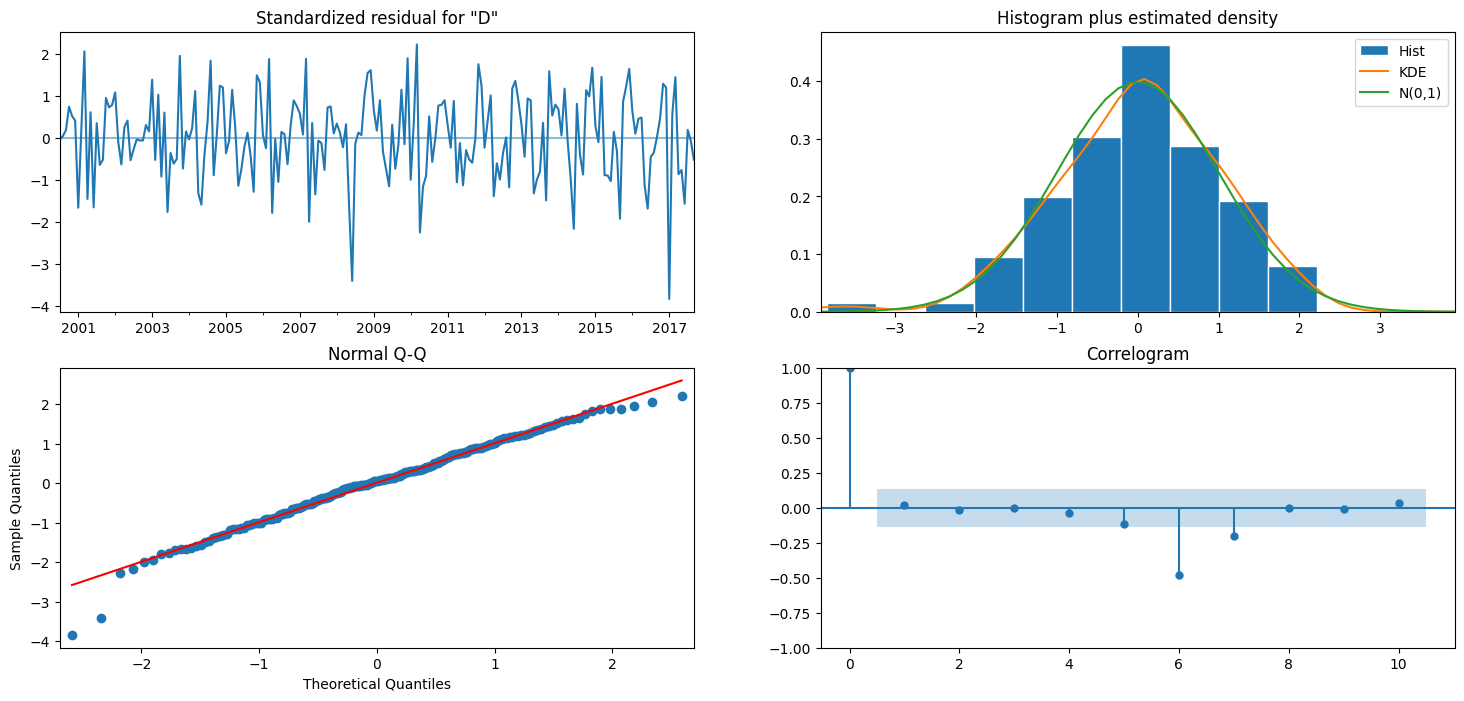

In [85]:
resultado_m510.plot_diagnostics(figsize=(18, 8))
plt.show()

In [86]:
modelo511 = SARIMAX(Gasd_df_log, order=(5,1,1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m511 = modelo511.fit()
print(resultado_m511.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7365      0.282     -2.610      0.009      -1.290      -0.184
ar.L2         -0.2176      0.116     -1.884      0.060      -0.444       0.009
ar.L3         -0.0320      0.119     -0.270      0.787      -0.265       0.201
ar.L4         -0.0270      0.100     -0.271      0.787      -0.223       0.169
ar.L5          0.1286      0.086      1.500      0.134      -0.039       0.297
ma.L1          0.5439      0.284      1.917      0.055      -0.012       1.100
sigma2         0.0091      0.001     10.923      0.000       0.007       0.011


c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


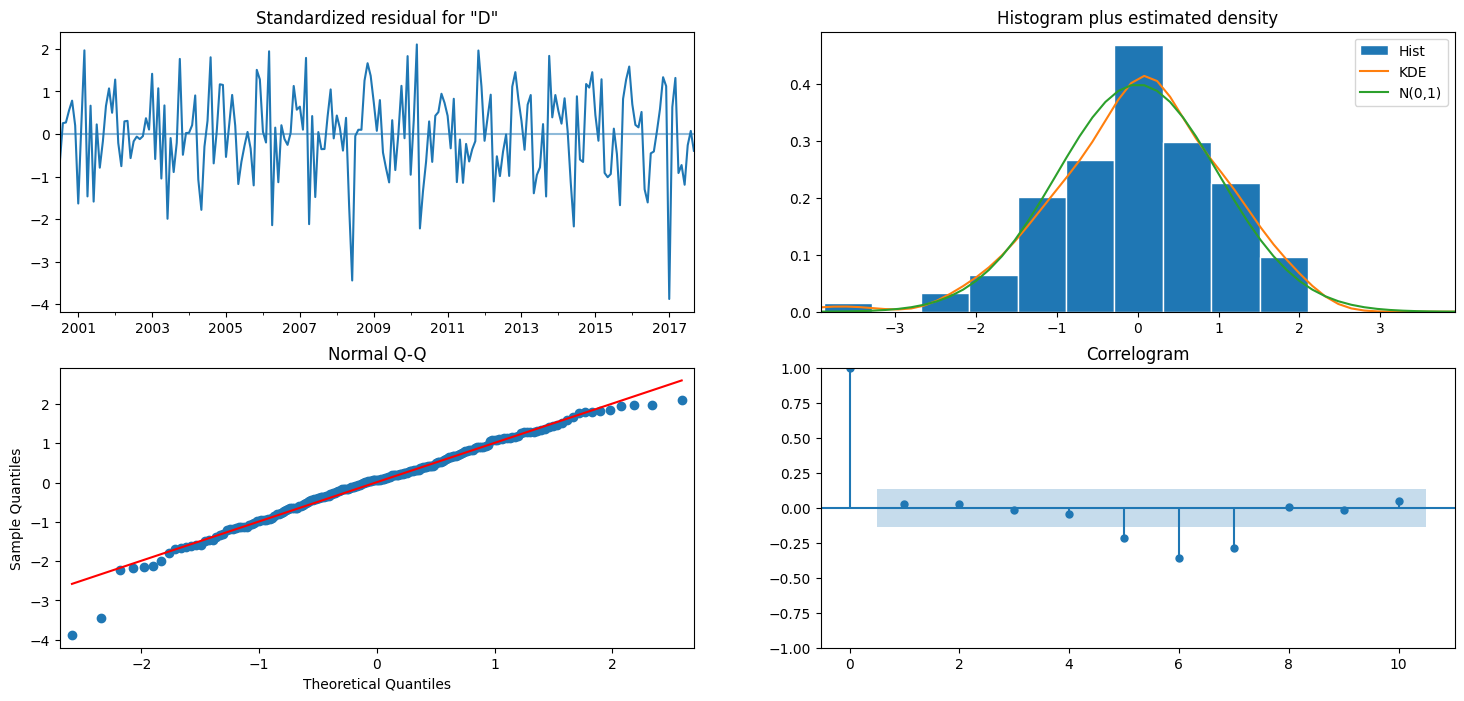

In [87]:
resultado_m511.plot_diagnostics(figsize=(18, 8))
plt.show()

In [88]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 010=",resultado_m010.aic)
print("Modelo 510=",resultado_m510.aic)
print("Modelo 511=",resultado_m511.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 010=",resultado_m010.bic)
print("Modelo 510=",resultado_m510.bic)
print("Modelo 511=",resultado_m511.bic)

Resultados de AIC (Akaike information criterion)
Modelo 010= -367.1450797399745
Modelo 510= -365.79183999538805
Modelo 511= -370.3314252621606
Resultados de BIC (Bayesian information criterion)
Modelo 010= -363.79322160649843
Modelo 510= -345.7955272357958
Modelo 511= -347.002393709303


De acuerdo a los indicadores se elegira el modelo p = 0, d = 1, q = 0 dado que aunque el 511 dio mejores resultados de acuerdo al AIC tambien fue el de menor rendimiento de acuerdo al BIC. Mientras que el 010 tuvo un buen desempeno bajo los 2 criterios.

# LSTM
Gas licuado


In [89]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
Gasl_df_diff = Gasl_df.diff()
Gasl_df_diff.dropna(inplace=True)
dfTest = adfuller(Gasl_df_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.573267
p-value                        0.000145
# de retardos usados          11.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


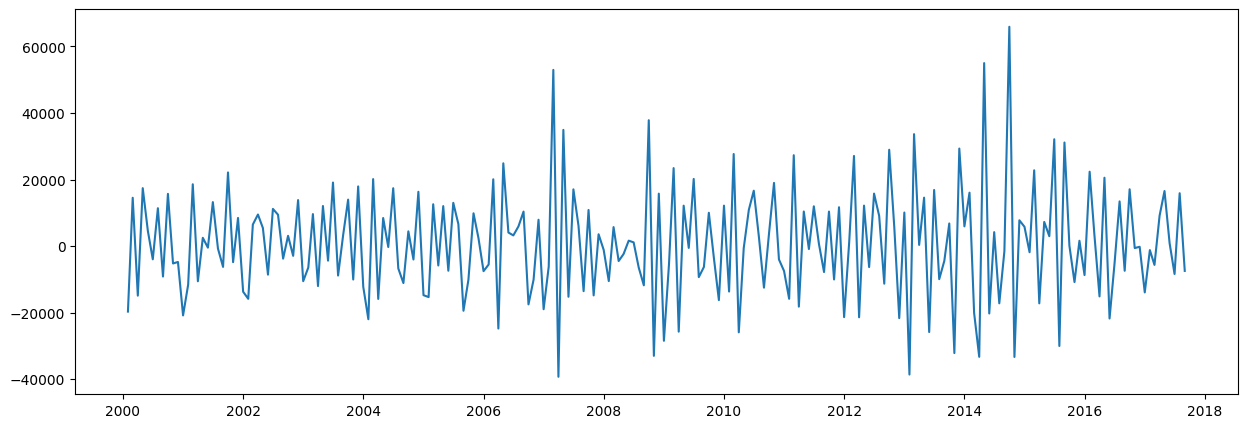

In [90]:
plt.plot(Gasl_df_diff)

In [91]:
scaler = StandardScaler()
Gasl_df_scaled = scaler.fit_transform(Gasl_df_diff.values.reshape(-1, 1))
Gasl_df_scaled[1:7]

array([[ 0.82471283],
       [-0.95249946],
       [ 0.99931344],
       [ 0.22399023],
       [-0.29263303],
       [ 0.6350192 ]])

In [92]:
entrenamiento = round(0.7*len(Gasl_df_scaled))
test = Gasl_df_scaled[(entrenamiento)-1:]
train = Gasl_df_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

65

In [93]:
from operator import concat

def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_test,y_test = supervisada(test)

In [94]:
print(train[0:7])
print(x_train[0:7])
print(y_train[0:7])

[[ 0.        ]
 [-1.24217707]
 [ 0.82471283]
 [-0.95249946]
 [ 0.99931344]
 [ 0.22399023]
 [-0.29263303]]
[[ 0.        ]
 [-1.24217707]
 [ 0.82471283]
 [-0.95249946]
 [ 0.99931344]
 [ 0.22399023]
 [-0.29263303]]
[-1.24217707  0.82471283 -0.95249946  0.99931344  0.22399023 -0.29263303
  0.6350192 ]


Modelo

In [95]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))

x_train

array([[[ 0.        ]],

       [[-1.24217707]],

       [[ 0.82471283]],

       [[-0.95249946]],

       [[ 0.99931344]],

       [[ 0.22399023]],

       [[-0.29263303]],

       [[ 0.6350192 ]],

       [[-0.60574882]],

       [[ 0.89556792]],

       [[-0.36851461]],

       [[-0.34112739]],

       [[-1.31112532]],

       [[-0.75225673]],

       [[ 1.06965115]],

       [[-0.69120617]],

       [[ 0.0975373 ]],

       [[-0.08119195]],

       [[ 0.74569018]],

       [[-0.09747403]],

       [[-0.4302449 ]],

       [[ 1.2845216 ]],

       [[-0.34478741]],

       [[ 0.45833184]],

       [[-0.88129024]],

       [[-1.01019672]],

       [[ 0.33839931]],

       [[ 0.52048905]],

       [[ 0.27643694]],

       [[-0.57108109]],

       [[ 0.62229217]],

       [[ 0.51704616]],

       [[-0.28044811]],

       [[ 0.13374853]],

       [[-0.22948205]],

       [[ 0.78281968]],

       [[-0.69026628]],

       [[-0.4422009 ]],

       [[ 0.52814356]],

       [[-0.77862388]],



In [96]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

#Tensor Flow 2
#modelo1 = Sequential()
#modelo1.add(LSTM(lote,batch_input_shape=(lote,paso,caracteristicas),stateful=True))
#modelo1.add(Dense(1))
#modelo1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [97]:
modelo1.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])

In [98]:
modelo1


<Functional name=functional, built=True>

In [99]:
epocas = 150
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/150
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6050 - root_mean_squared_error: 0.7737
Epoch 2/150
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5433 - root_mean_squared_error: 0.7334
Epoch 3/150
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5519 - root_mean_squared_error: 0.7389
Epoch 4/150
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5543 - root_mean_squared_error: 0.7405
Epoch 5/150
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5550 - root_mean_squared_error: 0.7410
Epoch 6/150
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5553 - root_mean_squared_error: 0.7413
Epoch 7/150
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5554 - root_mean_squared_error: 0.7414
Epoch 8/150
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5556 - root_mean_squared_error: 0.7415
Epoch 9/150
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5556 - root_mean_squared_error: 0.7415
Epoch 10/150
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5557 - root_mean_s

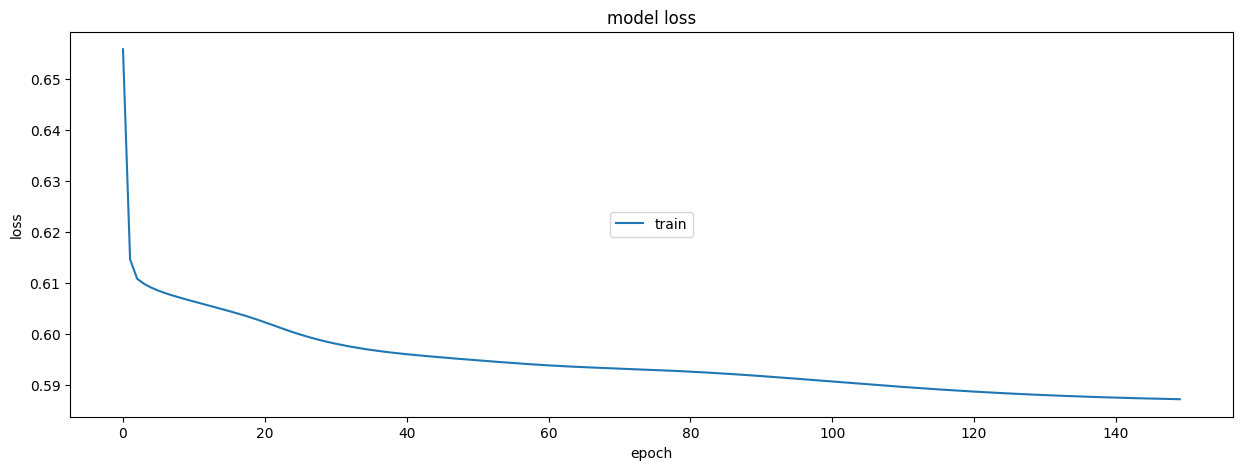

In [100]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

<Axes: >

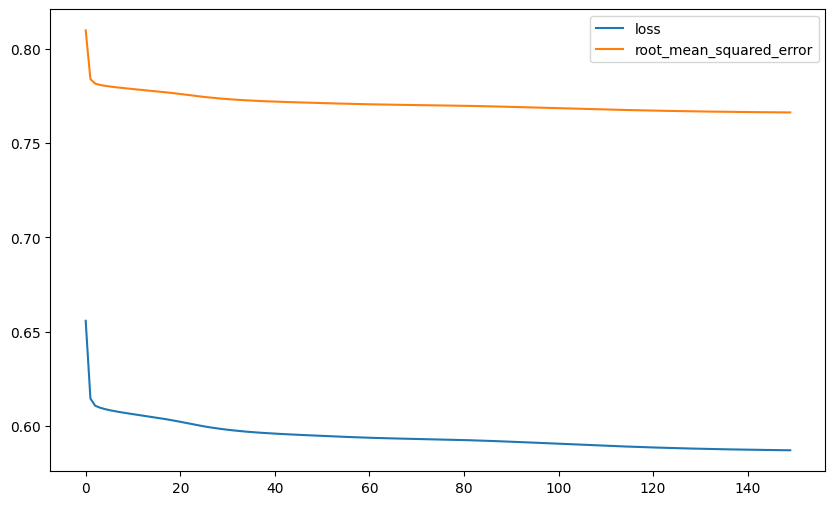

In [101]:
losses_df1 = pd.DataFrame(history.history)

losses_df1.plot(figsize = (10,6))

In [102]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)

print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5054 - root_mean_squared_error: 0.7098  
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.4137 - root_mean_squared_error: 1.1834


[1.2149690389633179, 1.1022562980651855]

In [103]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = df.values , n=entrenamiento)


In [104]:
plt.clf

<function matplotlib.pyplot.clf() -> 'None'>

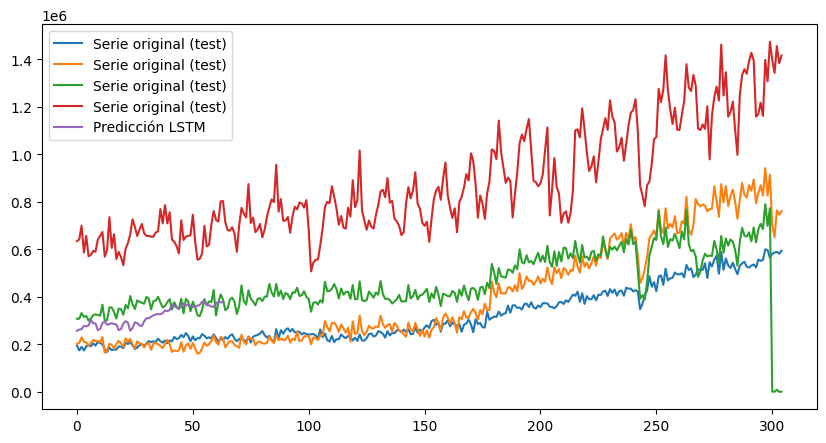

In [108]:
df_test = pd.DataFrame(prediccion_test, index=test_df.index[-len(prediccion_test):])

# ...existing code...
plt.figure(figsize=(10,5))
plt.plot(df.values, label='Serie original (test)')
plt.plot(df_test.values, label='Predicción LSTM')
plt.legend()
plt.show()
# ...existing code...

